In [1]:
import pandas as pd
import plotly.graph_objs as go 
import plotly.offline as py 
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import igraph as ig
from tqdm import tqdm
from scipy.stats import kde


In [23]:
#load datasets
df_classes = pd.read_csv("/Users/roy/Documents/UNI/3r/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_edges = pd.read_csv("/Users/roy/Documents/UNI/3r/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
df_features = pd.read_csv("/Users/roy/Documents/UNI/3r/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None, names = feat_cols)


In [3]:
df_features.head

<bound method NDFrame.head of               0    1         2         3         4          5         6    \
0       230425980    1 -0.171469 -0.184668 -1.201369  -0.121970 -0.043875   
1         5530458    1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
2       232022460    1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
3       232438397    1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
4       230460314    1  1.011523 -0.081127 -1.201369   1.153668  0.333276   
...           ...  ...       ...       ...       ...        ...       ...   
203764  173077460   49 -0.145771 -0.163752  0.463609  -0.121970 -0.043875   
203765  158577750   49 -0.165920 -0.123607  1.018602  -0.121970 -0.043875   
203766  158375402   49 -0.172014 -0.078182  1.018602   0.028105 -0.043875   
203767  158654197   49 -0.172842 -0.176622  1.018602  -0.121970 -0.043875   
203768  157597225   49 -0.012037 -0.132276  0.463609  -0.121970 -0.043875   

             7          8         9    ...   

In [4]:
df_classes.head



<bound method NDFrame.head of              txId    class
0       230425980  unknown
1         5530458  unknown
2       232022460  unknown
3       232438397        2
4       230460314  unknown
...           ...      ...
203764  173077460  unknown
203765  158577750  unknown
203766  158375402        1
203767  158654197  unknown
203768  157597225  unknown

[203769 rows x 2 columns]>

In [5]:
len(df_edges),len(df_features),len(df_classes)

(234355, 203769, 203769)

In [6]:
display(df_edges.head(5),df_features.head(5),df_classes.head(5))

txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206

0    1         2         3         4          5         6    \
0  230425980    1 -0.171469 -0.184668 -1.201369  -0.121970 -0.043875   
1    5530458    1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
2  232022460    1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
3  232438397    1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
4  230460314    1  1.011523 -0.081127 -1.201369   1.153668  0.333276   

        7          8         9    ...       157       158       159       160  \
0 -0.113002  -0.061584 -0.162097  ... -0.562153 -0.600999  1.461330  1.461369   
1 -0.113002  -0.061584 -0.162112  ...  0.947382  0.673103 -0.979074 -0.978556   
2 -0.113002  -0.061584 -0.162749  ...  0.670883  0.439728 -0.979074 -0.978556   
3  9.782742  12.414558 -0.163645  ... -0.577099 -0.613614  0.241128  0.241406   
4  1.312656  -0.061584 -0.163523  ... -0.511871 -0.400422  0.517257  0.579382   

        161       162       163       164       165       166  
0  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
1  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
2 -0.098889 -0.106715 -0.131155 -0.183671 -0.120613 -0.119792  
3  1.072793  0.085530 -0.131155  0.677799 -0.120613 -0.119792  
4  0.018279  0.277775  0.326394  1.293750  0.178136  0.179117  

[5 rows x 167 columns]

txId    class
0  230425980  unknown
1    5530458  unknown
2  232022460  unknown
3  232438397        2
4  230460314  unknown

### Proving the imbalance of the dataset

In [7]:
df_classes.groupby('class').size()

class
1            4545
2           42019
unknown    157205
dtype: int64

In [8]:
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
df_features.columns = ["txId","time_step"] + tx_features + agg_features
features = pd.merge(df_features,df_classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

In [9]:
count_by_class = features[["time_step",'class']].groupby(['time_step','class']).size().to_frame().reset_index()
illicit_count = count_by_class[count_by_class['class'] == '1']
licit_count = count_by_class[count_by_class['class'] == '2']
unknown_count = count_by_class[count_by_class['class'] == "0"]

In [10]:
x_list = list(range(1,50))
fig = go.Figure(data = [
    go.Bar(name="Unknown",x=x_list,y=unknown_count[0],marker = dict(color = 'rgba(120, 100, 180, 0.6)',
        line = dict(
            color = 'rgba(120, 100, 180, 1.0)',width=1))),
    go.Bar(name="Licit",x=x_list,y=licit_count[0],marker = dict(color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',width=1))),
    go.Bar(name="Illicit",x=x_list,y=illicit_count[0],marker = dict(color = 'rgba(58, 190, 120, 0.6)',
        line = dict(
            color = 'rgba(58, 190, 120, 1.0)',width=1)))

])
fig.update_layout(barmode='stack')
py.iplot(fig)

<BarContainer object of 3 artists>

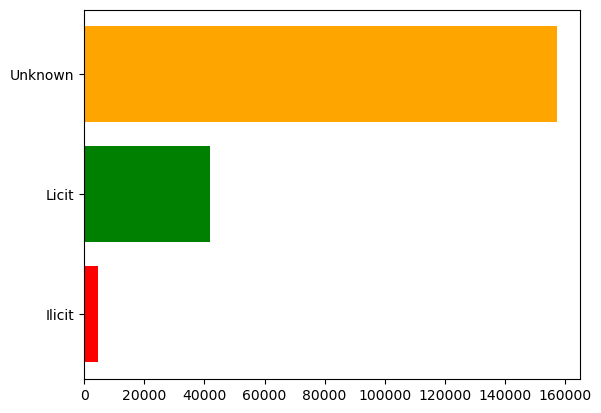

In [11]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

group_class = df_classes.groupby('class').count()
plt.barh(['Ilicit', 'Licit', 'Unknown'], group_class['txId'].values, color=['r', 'g', 'orange'] )

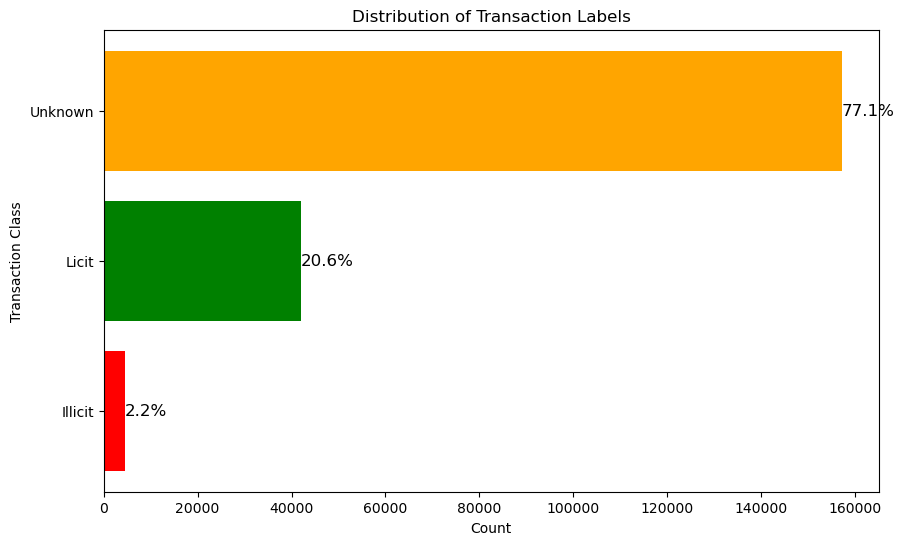

In [12]:
group_class = df_classes.groupby('class').count()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(['Illicit', 'Licit', 'Unknown'], group_class['txId'].values, color=['red', 'green', 'orange'])

# Adding percentage annotations
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width() / len(df_classes) * 100:.1f}%', 
             va='center', ha='left', fontsize=12, color='black')

plt.xlabel('Count')
plt.ylabel('Transaction Class')
plt.title('Distribution of Transaction Labels')
plt.show()

In [13]:
df_classes = df_classes.rename(columns={'txId': 'tx_id'})

features_columns = ['tx_id'] + [f'feature_{i}' for i in range(1, 167)]
df_features.columns = features_columns

data = df_features.merge(df_classes, left_on='tx_id', right_on='tx_id')

data

tx_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       230425980          1  -0.171469  -0.184668  -1.201369  -0.121970   
1         5530458          1  -0.171484  -0.184668  -1.201369  -0.121970   
2       232022460          1  -0.172107  -0.184668  -1.201369  -0.121970   
3       232438397          1   0.163054   1.963790  -0.646376  12.409294   
4       230460314          1   1.011523  -0.081127  -1.201369   1.153668   
...           ...        ...        ...        ...        ...        ...   
203764  173077460         49  -0.145771  -0.163752   0.463609  -0.121970   
203765  158577750         49  -0.165920  -0.123607   1.018602  -0.121970   
203766  158375402         49  -0.172014  -0.078182   1.018602   0.028105   
203767  158654197         49  -0.172842  -0.176622   1.018602  -0.121970   
203768  157597225         49  -0.012037  -0.132276   0.463609  -0.121970   

        feature_6  feature_7  feature_8  feature_9  ...  feature_158  \
0       -0.043875  -0.113002  -0.061584  -0.162097  ...    -0.600999   
1       -0.043875  -0.113002  -0.061584  -0.162112  ...     0.673103   
2       -0.043875  -0.113002  -0.061584  -0.162749  ...     0.439728   
3       -0.063725   9.782742  12.414558  -0.163645  ...    -0.613614   
4        0.333276   1.312656  -0.061584  -0.163523  ...    -0.400422   
...           ...        ...        ...        ...  ...          ...   
203764  -0.043875  -0.113002  -0.061584  -0.135803  ...    -0.613614   
203765  -0.043875  -0.113002  -0.061584  -0.156418  ...     0.010822   
203766  -0.043875   0.054722  -0.061584  -0.163626  ...     1.985050   
203767  -0.043875  -0.113002  -0.061584  -0.163501  ...    -0.411776   
203768  -0.043875  -0.113002  -0.061584   0.001027  ...    -0.613614   

        feature_159  feature_160  feature_161  feature_162  feature_163  \
0          1.461330     1.461369     0.018279    -0.087490    -0.131155   
1         -0.979074    -0.978556     0.018279    -0.087490    -0.131155   
2         -0.979074    -0.978556    -0.098889    -0.106715    -0.131155   
3          0.241128     0.241406     1.072793     0.085530    -0.131155   
4          0.517257     0.579382     0.018279     0.277775     0.326394   
...             ...          ...          ...          ...          ...   
203764     0.241128     0.241406     0.018279    -0.087490    -0.131155   
203765     1.461330     1.461369    -0.098889    -0.087490    -0.084674   
203766     1.461330     1.461369     0.018279    -0.087490    -0.131155   
203767     1.461330     1.461369    -0.098889    -0.087490    -0.084674   
203768     0.241128     0.241406    -0.098889    -0.087490    -0.084674   

        feature_164  feature_165  feature_166    class  
0         -0.097524    -0.120613    -0.119792  unknown  
1         -0.097524    -0.120613    -0.119792  unknown  
2         -0.183671    -0.120613    -0.119792  unknown  
3          0.677799    -0.120613    -0.119792        2  
4          1.293750     0.178136     0.179117  unknown  
...             ...          ...          ...      ...  
203764    -0.097524    -0.120613    -0.119792  unknown  
203765    -0.140597    -1.760926    -1.760984  unknown  
203766    -0.097524    -0.120613    -0.119792        1  
203767    -0.140597     1.519700     1.521399  unknown  
203768    -0.140597     1.519700     1.521399  unknown  

[203769 rows x 168 columns]

In [14]:
class_map = {'1': 'illicit', '2': 'licit'}

data['class'] = data['class'].replace(class_map)

data

tx_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       230425980          1  -0.171469  -0.184668  -1.201369  -0.121970   
1         5530458          1  -0.171484  -0.184668  -1.201369  -0.121970   
2       232022460          1  -0.172107  -0.184668  -1.201369  -0.121970   
3       232438397          1   0.163054   1.963790  -0.646376  12.409294   
4       230460314          1   1.011523  -0.081127  -1.201369   1.153668   
...           ...        ...        ...        ...        ...        ...   
203764  173077460         49  -0.145771  -0.163752   0.463609  -0.121970   
203765  158577750         49  -0.165920  -0.123607   1.018602  -0.121970   
203766  158375402         49  -0.172014  -0.078182   1.018602   0.028105   
203767  158654197         49  -0.172842  -0.176622   1.018602  -0.121970   
203768  157597225         49  -0.012037  -0.132276   0.463609  -0.121970   

        feature_6  feature_7  feature_8  feature_9  ...  feature_158  \
0       -0.043875  -0.113002  -0.061584  -0.162097  ...    -0.600999   
1       -0.043875  -0.113002  -0.061584  -0.162112  ...     0.673103   
2       -0.043875  -0.113002  -0.061584  -0.162749  ...     0.439728   
3       -0.063725   9.782742  12.414558  -0.163645  ...    -0.613614   
4        0.333276   1.312656  -0.061584  -0.163523  ...    -0.400422   
...           ...        ...        ...        ...  ...          ...   
203764  -0.043875  -0.113002  -0.061584  -0.135803  ...    -0.613614   
203765  -0.043875  -0.113002  -0.061584  -0.156418  ...     0.010822   
203766  -0.043875   0.054722  -0.061584  -0.163626  ...     1.985050   
203767  -0.043875  -0.113002  -0.061584  -0.163501  ...    -0.411776   
203768  -0.043875  -0.113002  -0.061584   0.001027  ...    -0.613614   

        feature_159  feature_160  feature_161  feature_162  feature_163  \
0          1.461330     1.461369     0.018279    -0.087490    -0.131155   
1         -0.979074    -0.978556     0.018279    -0.087490    -0.131155   
2         -0.979074    -0.978556    -0.098889    -0.106715    -0.131155   
3          0.241128     0.241406     1.072793     0.085530    -0.131155   
4          0.517257     0.579382     0.018279     0.277775     0.326394   
...             ...          ...          ...          ...          ...   
203764     0.241128     0.241406     0.018279    -0.087490    -0.131155   
203765     1.461330     1.461369    -0.098889    -0.087490    -0.084674   
203766     1.461330     1.461369     0.018279    -0.087490    -0.131155   
203767     1.461330     1.461369    -0.098889    -0.087490    -0.084674   
203768     0.241128     0.241406    -0.098889    -0.087490    -0.084674   

        feature_164  feature_165  feature_166    class  
0         -0.097524    -0.120613    -0.119792  unknown  
1         -0.097524    -0.120613    -0.119792  unknown  
2         -0.183671    -0.120613    -0.119792  unknown  
3          0.677799    -0.120613    -0.119792    licit  
4          1.293750     0.178136     0.179117  unknown  
...             ...          ...          ...      ...  
203764    -0.097524    -0.120613    -0.119792  unknown  
203765    -0.140597    -1.760926    -1.760984  unknown  
203766    -0.097524    -0.120613    -0.119792  illicit  
203767    -0.140597     1.519700     1.521399  unknown  
203768    -0.140597     1.519700     1.521399  unknown  

[203769 rows x 168 columns]

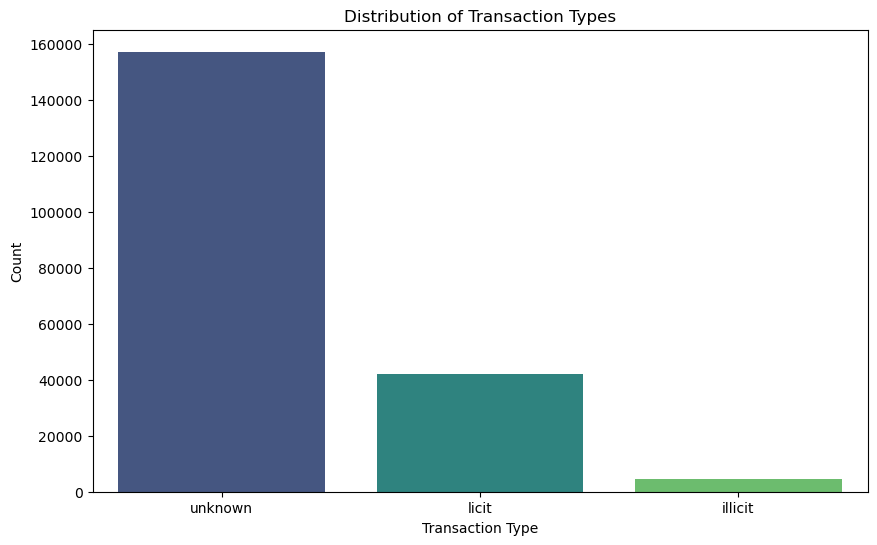

In [15]:
transaction_counts = data['class'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=transaction_counts.index, y=transaction_counts.values, palette='viridis')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

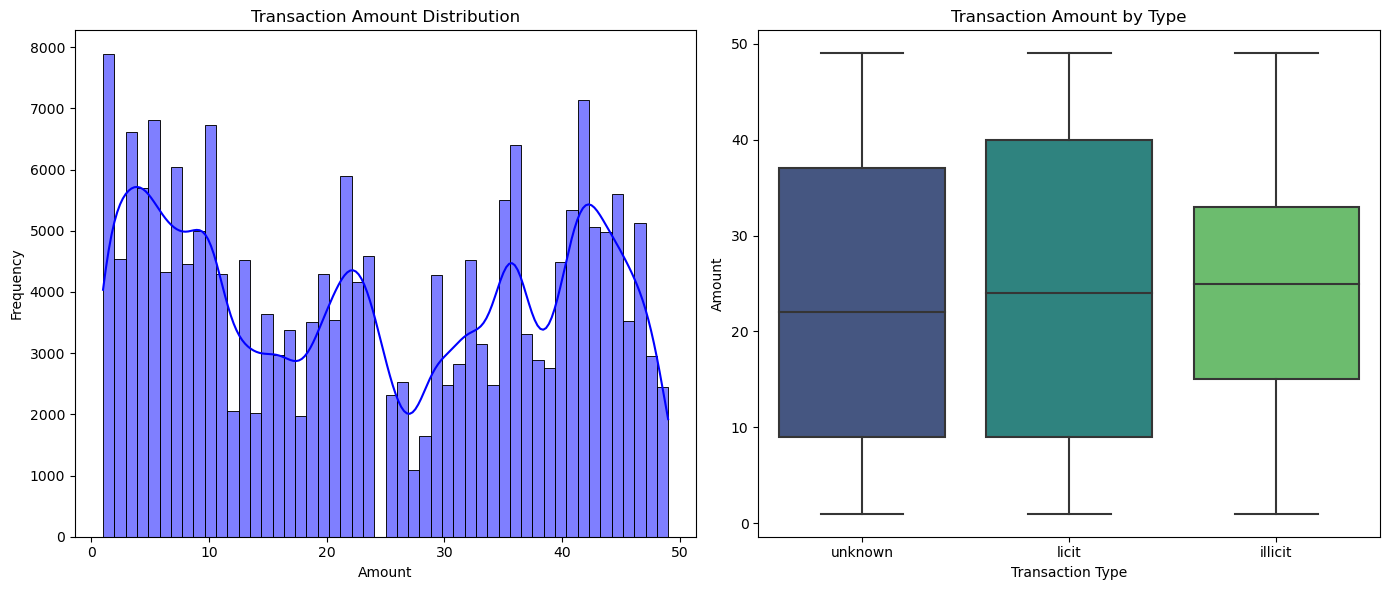

In [16]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['feature_1'], bins=50, kde=True, color='blue')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='feature_1', data=data, palette='viridis')
plt.title('Transaction Amount by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')

plt.tight_layout()
plt.show()

### Correlation matrix 

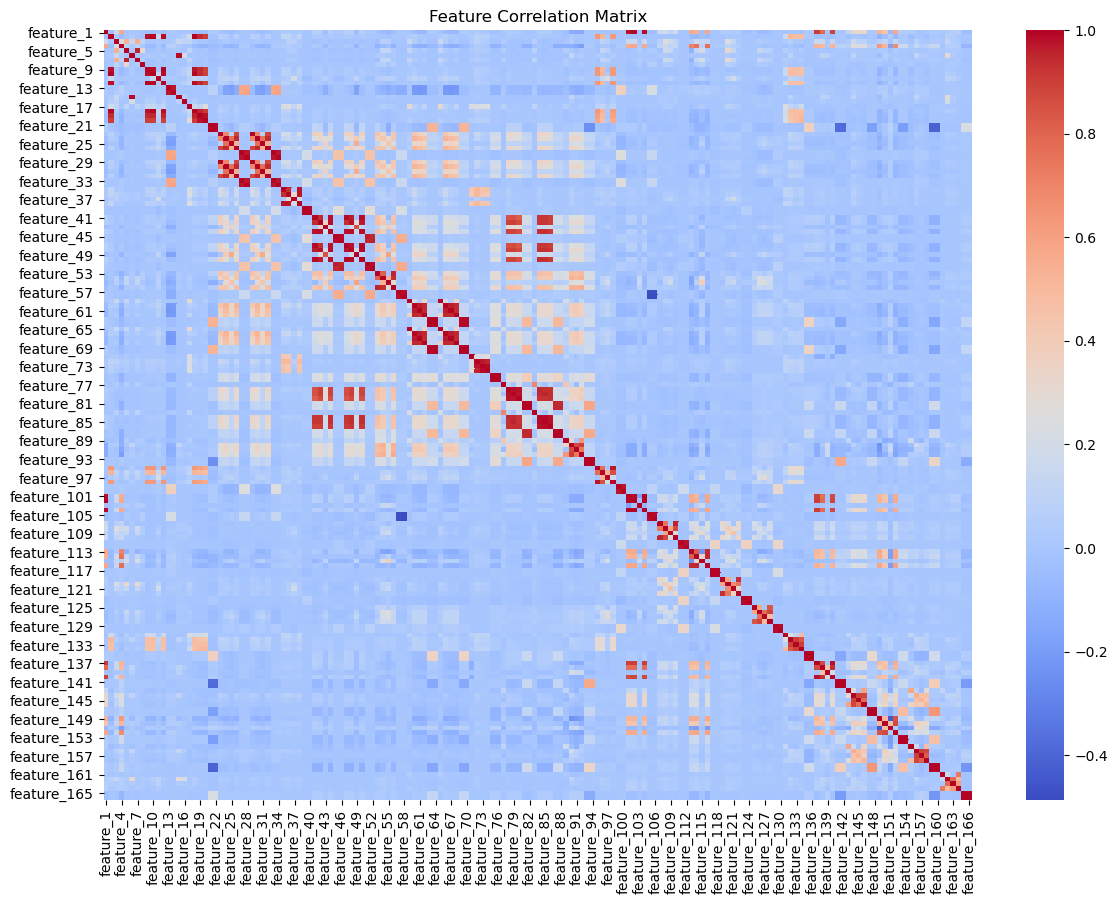

In [17]:
plt.figure(figsize=(14, 10))
correlation_matrix = data.drop(columns=['tx_id']).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Plotting the different nodes added in each timestep

In [20]:
df_features

tx_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       230425980          1  -0.171469  -0.184668  -1.201369  -0.121970   
1         5530458          1  -0.171484  -0.184668  -1.201369  -0.121970   
2       232022460          1  -0.172107  -0.184668  -1.201369  -0.121970   
3       232438397          1   0.163054   1.963790  -0.646376  12.409294   
4       230460314          1   1.011523  -0.081127  -1.201369   1.153668   
...           ...        ...        ...        ...        ...        ...   
203764  173077460         49  -0.145771  -0.163752   0.463609  -0.121970   
203765  158577750         49  -0.165920  -0.123607   1.018602  -0.121970   
203766  158375402         49  -0.172014  -0.078182   1.018602   0.028105   
203767  158654197         49  -0.172842  -0.176622   1.018602  -0.121970   
203768  157597225         49  -0.012037  -0.132276   0.463609  -0.121970   

        feature_6  feature_7  feature_8  feature_9  ...  feature_157  \
0       -0.043875  -0.113002  -0.061584  -0.162097  ...    -0.562153   
1       -0.043875  -0.113002  -0.061584  -0.162112  ...     0.947382   
2       -0.043875  -0.113002  -0.061584  -0.162749  ...     0.670883   
3       -0.063725   9.782742  12.414558  -0.163645  ...    -0.577099   
4        0.333276   1.312656  -0.061584  -0.163523  ...    -0.511871   
...           ...        ...        ...        ...  ...          ...   
203764  -0.043875  -0.113002  -0.061584  -0.135803  ...    -0.577099   
203765  -0.043875  -0.113002  -0.061584  -0.156418  ...     0.162722   
203766  -0.043875   0.054722  -0.061584  -0.163626  ...     1.261246   
203767  -0.043875  -0.113002  -0.061584  -0.163501  ...    -0.397749   
203768  -0.043875  -0.113002  -0.061584   0.001027  ...    -0.577099   

        feature_158  feature_159  feature_160  feature_161  feature_162  \
0         -0.600999     1.461330     1.461369     0.018279    -0.087490   
1          0.673103    -0.979074    -0.978556     0.018279    -0.087490   
2          0.439728    -0.979074    -0.978556    -0.098889    -0.106715   
3         -0.613614     0.241128     0.241406     1.072793     0.085530   
4         -0.400422     0.517257     0.579382     0.018279     0.277775   
...             ...          ...          ...          ...          ...   
203764    -0.613614     0.241128     0.241406     0.018279    -0.087490   
203765     0.010822     1.461330     1.461369    -0.098889    -0.087490   
203766     1.985050     1.461330     1.461369     0.018279    -0.087490   
203767    -0.411776     1.461330     1.461369    -0.098889    -0.087490   
203768    -0.613614     0.241128     0.241406    -0.098889    -0.087490   

        feature_163  feature_164  feature_165  feature_166  
0         -0.131155    -0.097524    -0.120613    -0.119792  
1         -0.131155    -0.097524    -0.120613    -0.119792  
2         -0.131155    -0.183671    -0.120613    -0.119792  
3         -0.131155     0.677799    -0.120613    -0.119792  
4          0.326394     1.293750     0.178136     0.179117  
...             ...          ...          ...          ...  
203764    -0.131155    -0.097524    -0.120613    -0.119792  
203765    -0.084674    -0.140597    -1.760926    -1.760984  
203766    -0.131155    -0.097524    -0.120613    -0.119792  
203767    -0.084674    -0.140597     1.519700     1.521399  
203768    -0.084674    -0.140597     1.519700     1.521399  

[203769 rows x 167 columns]

In [25]:
df_classes.columns = ['txId', 'label']

df = df_classes.set_index('txId').join(df_features.set_index('txId'))

total = df['time_step'].value_counts().sort_index()
illicit = df['time_step'][df['label']=='1'].value_counts().sort_index()
licit = df['time_step'][df['label']=='2'].value_counts().sort_index()
unknown = df['time_step'][df['label']=='unknown'].value_counts().sort_index()

In [22]:
df

label  feature_1  feature_2  feature_3  feature_4  feature_5  \
txId                                                                        
230425980  unknown          1  -0.171469  -0.184668  -1.201369  -0.121970   
5530458    unknown          1  -0.171484  -0.184668  -1.201369  -0.121970   
232022460  unknown          1  -0.172107  -0.184668  -1.201369  -0.121970   
232438397        2          1   0.163054   1.963790  -0.646376  12.409294   
230460314  unknown          1   1.011523  -0.081127  -1.201369   1.153668   
...            ...        ...        ...        ...        ...        ...   
173077460  unknown         49  -0.145771  -0.163752   0.463609  -0.121970   
158577750  unknown         49  -0.165920  -0.123607   1.018602  -0.121970   
158375402        1         49  -0.172014  -0.078182   1.018602   0.028105   
158654197  unknown         49  -0.172842  -0.176622   1.018602  -0.121970   
157597225  unknown         49  -0.012037  -0.132276   0.463609  -0.121970   

           feature_6  feature_7  feature_8  feature_9  ...  feature_157  \
txId                                                   ...                
230425980  -0.043875  -0.113002  -0.061584  -0.162097  ...    -0.562153   
5530458    -0.043875  -0.113002  -0.061584  -0.162112  ...     0.947382   
232022460  -0.043875  -0.113002  -0.061584  -0.162749  ...     0.670883   
232438397  -0.063725   9.782742  12.414558  -0.163645  ...    -0.577099   
230460314   0.333276   1.312656  -0.061584  -0.163523  ...    -0.511871   
...              ...        ...        ...        ...  ...          ...   
173077460  -0.043875  -0.113002  -0.061584  -0.135803  ...    -0.577099   
158577750  -0.043875  -0.113002  -0.061584  -0.156418  ...     0.162722   
158375402  -0.043875   0.054722  -0.061584  -0.163626  ...     1.261246   
158654197  -0.043875  -0.113002  -0.061584  -0.163501  ...    -0.397749   
157597225  -0.043875  -0.113002  -0.061584   0.001027  ...    -0.577099   

           feature_158  feature_159  feature_160  feature_161  feature_162  \
txId                                                                         
230425980    -0.600999     1.461330     1.461369     0.018279    -0.087490   
5530458       0.673103    -0.979074    -0.978556     0.018279    -0.087490   
232022460     0.439728    -0.979074    -0.978556    -0.098889    -0.106715   
232438397    -0.613614     0.241128     0.241406     1.072793     0.085530   
230460314    -0.400422     0.517257     0.579382     0.018279     0.277775   
...                ...          ...          ...          ...          ...   
173077460    -0.613614     0.241128     0.241406     0.018279    -0.087490   
158577750     0.010822     1.461330     1.461369    -0.098889    -0.087490   
158375402     1.985050     1.461330     1.461369     0.018279    -0.087490   
158654197    -0.411776     1.461330     1.461369    -0.098889    -0.087490   
157597225    -0.613614     0.241128     0.241406    -0.098889    -0.087490   

           feature_163  feature_164  feature_165  feature_166  
txId                                                           
230425980    -0.131155    -0.097524    -0.120613    -0.119792  
5530458      -0.131155    -0.097524    -0.120613    -0.119792  
232022460    -0.131155    -0.183671    -0.120613    -0.119792  
232438397    -0.131155     0.677799    -0.120613    -0.119792  
230460314     0.326394     1.293750     0.178136     0.179117  
...                ...          ...          ...          ...  
173077460    -0.131155    -0.097524    -0.120613    -0.119792  
158577750    -0.084674    -0.140597    -1.760926    -1.760984  
158375402    -0.131155    -0.097524    -0.120613    -0.119792  
158654197    -0.084674    -0.140597     1.519700     1.521399  
157597225    -0.084674    -0.140597     1.519700     1.521399  

[203769 rows x 167 columns]

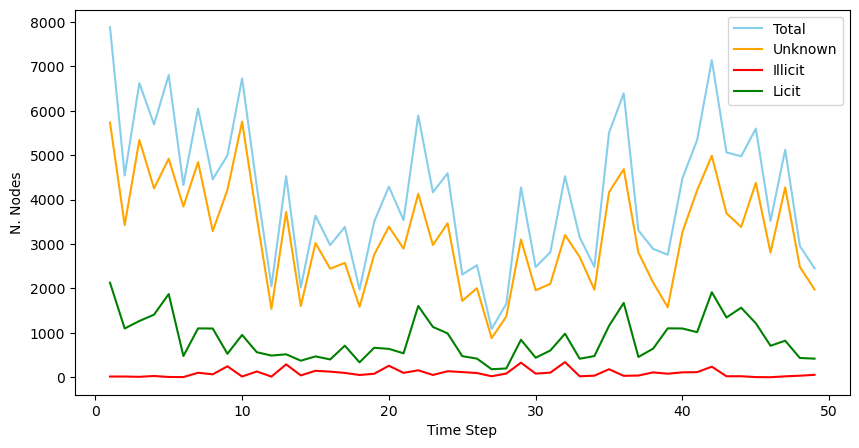

In [26]:
plt.figure(figsize=(10, 5))
step = np.arange(1, 50, dtype=int)

plt.plot(step, total, label='Total', color='skyblue')  # Total in blue
plt.plot(step, unknown, label='Unknown', color='orange')  # Unknown in gray
plt.plot(step, illicit, label='Illicit', color='red')  # Illicit in red
plt.plot(step, licit, label='Licit', color='green')  # Licit in green

plt.xlabel('Time Step')
plt.ylabel('N. Nodes')
plt.legend()
plt.show()

In [29]:
num_tx = len(df_classes)
num_ed = len(df_edges)

tx_graph = ig.Graph(num_tx, directed=True)

edges_dict = dict()
for i in range(len(df_classes)):
    edges_dict[df_classes.txId[i]] = i
    
colors = {'1':'red', '2':'green', 'unknown':'gray'}

tx_graph.vs['id'] = list(str(i) for i in df_classes.txId)
tx_graph.vs['type'] = list(df_classes.label)
tx_graph.vs['time_step'] = list(df_features.time_step)
tx_graph.vs['color'] = [colors[i] for i in df_classes.label]

edges_list = []
for i in tqdm(range(len(df_edges))):
    src = edges_dict[df_edges['txId1'][i]]
    dst = edges_dict[df_edges['txId2'][i]]
    edges_list.append((src, dst))
tx_graph.add_edges(edges_list)

100%|██████████| 234355/234355 [00:01<00:00, 121627.42it/s]


### Plotting main overall metrics of the graph

In [30]:
diameter = tx_graph.diameter()
radius = tx_graph.radius()
average_path_length = tx_graph.average_path_length()

print(f"Graph diameter: {diameter}")
print(f"Graph radius: {radius}")
print(f"Average path length: {average_path_length}")

Graph diameter: 1248
Graph radius: 0
Average path length: 129.80861706805788


### Degree distribution over the graph

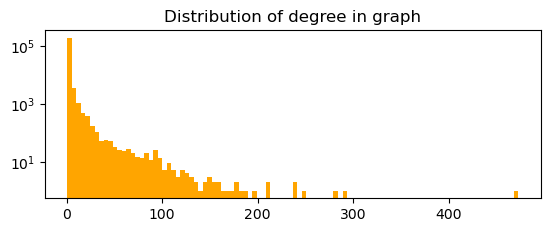

In [31]:
x = pd.Series(tx_graph.degree())

plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=100, color ='orange')
plt.yscale('log')
plt.title("Distribution of degree in graph")
plt.show()

In [32]:
average_degree = x.mean()
max_degree = tx_graph.maxdegree()
print(f"Average degree of vertices: {average_degree}")
print(f"Max degree of vertices: {max_degree}")

Average degree of vertices: 2.3002026804862368
Max degree of vertices: 473


### Plotting the indegree and outdegree to see some patterns in each class

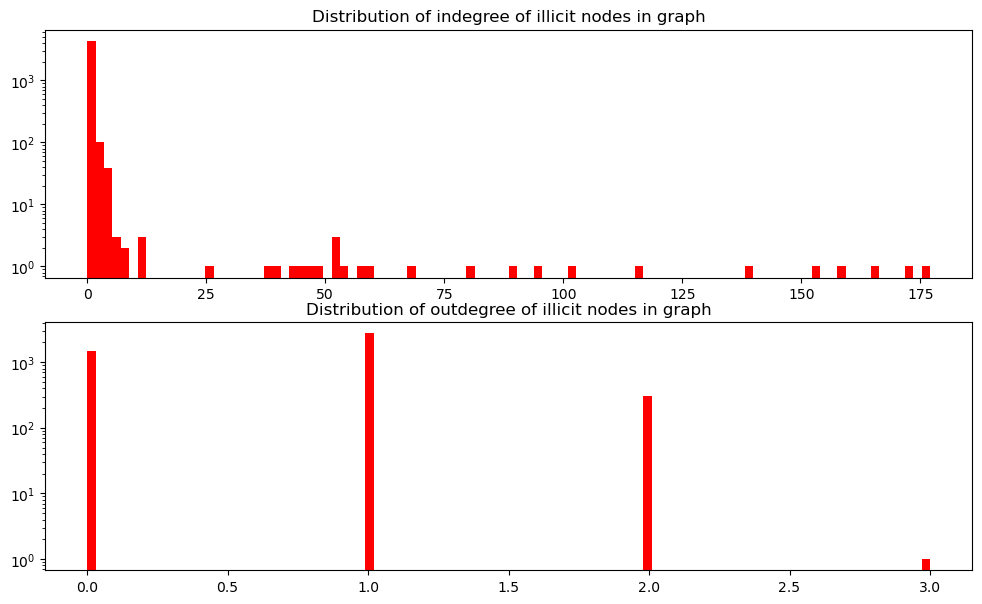

Max degree of a illicit node: 177
Mean degree of a illicit node: 2.0116611661166117


In [33]:
illicit_vertices = list(edges_dict[i] for i in classes['txId'][classes['label']=='1'])
x = tx_graph.degree(illicit_vertices)

in_degree = [tx_graph.vs[i].indegree() for i in illicit_vertices]
out_degree = [tx_graph.vs[i].outdegree() for i in illicit_vertices]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.tight_layout()
plt.subplot(211)
hist, bins, _ = plt.hist(in_degree, bins=100, color = 'red')
plt.yscale('log')
plt.title("Distribution of indegree of illicit nodes in graph")


plt.subplot(212)
hist, bins, _ = plt.hist(out_degree, bins=100, color = 'red')
plt.yscale('log')
plt.title("Distribution of outdegree of illicit nodes in graph")
plt.show()

print(f"Max degree of a illicit node: {max(x)}")
print(f"Mean degree of a illicit node: {sum(x)/len(x)}")

Max degree of a illicit node: 177
Mean degree of a illicit node: 2.0116611661166117


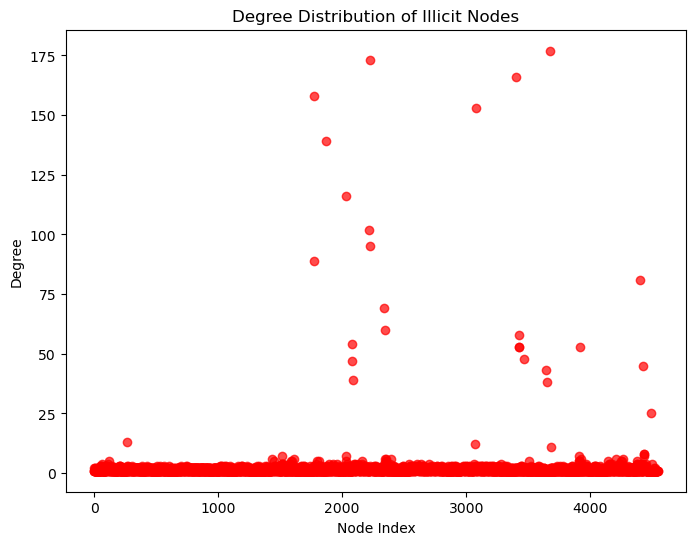

In [34]:
import matplotlib.pyplot as plt
import numpy as np

illicit_vertices = list(edges_dict[i] for i in classes['txId'][classes['label']=='1'])
x = tx_graph.degree(illicit_vertices)

# Scatter plot with transparency
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(len(x)), x, alpha=0.7, color='red')  # Red color for illicit
ax.set_xlabel('Node Index')
ax.set_ylabel('Degree')
ax.set_title('Degree Distribution of Illicit Nodes')

# Additional statistics (optional)
print(f"Max degree of a illicit node: {max(x)}")
print(f"Mean degree of a illicit node: {sum(x)/len(x)}")

plt.show()

Max degree of a illicit node: 177
Mean degree of a illicit node: 2.0116611661166117


/var/folders/_4/473sklf50p9_zw8_mv1wqcqm0000gn/T/ipykernel_73335/3308558042.py:5: DeprecationWarning:

Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.



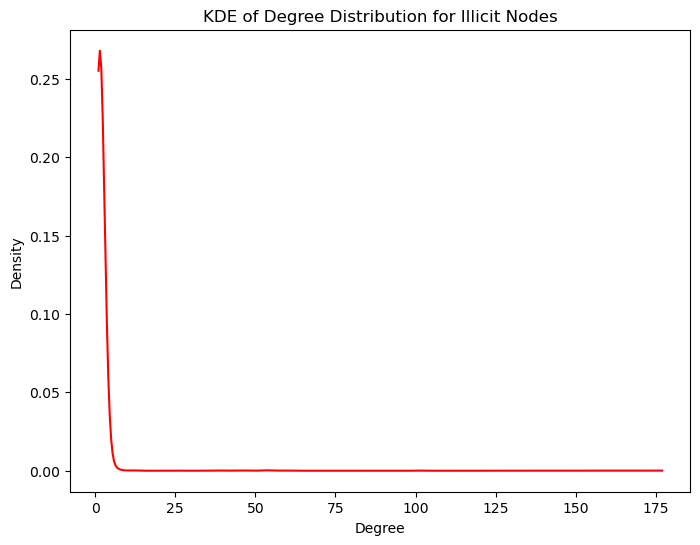

In [39]:
illicit_vertices = list(edges_dict[i] for i in classes['txId'][classes['label']=='1'])
x = tx_graph.degree(illicit_vertices)

# Kernel density estimation
density = kde.gaussian_kde(x)
x_grid = np.linspace(min(x), max(x), 400)  # Define grid for smoother plot
density_values = density(x_grid)

# Plot the KDE
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_grid, density_values, color='red')  
ax.set_xlabel('Degree')
ax.set_ylabel('Density')
ax.set_title('KDE of Degree Distribution for Illicit Nodes')

# Additional statistics (optional)
print(f"Max degree of a illicit node: {max(x)}")
print(f"Mean degree of a illicit node: {sum(x)/len(x)}")

plt.show()

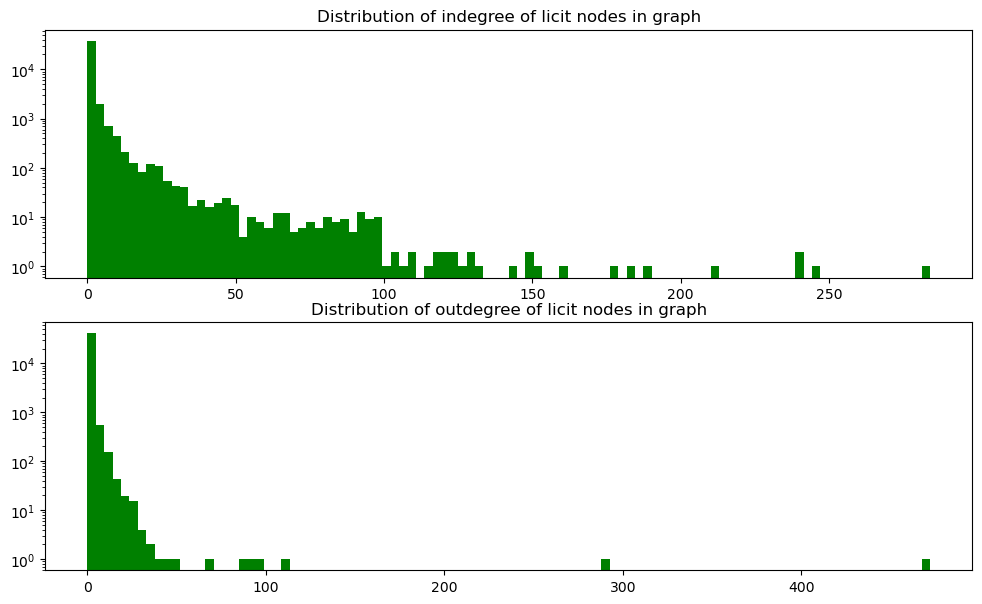

Max degree of a licit node: 473
Mean degree of a licit node: 3.095218829577096


In [40]:
licit_vertices = list(edges_dict[i] for i in df_classes['txId'][df_classes['label']=='2'])
x = tx_graph.degree(licit_vertices)


in_degree = [tx_graph.vs[i].indegree() for i in licit_vertices]
out_degree = [tx_graph.vs[i].outdegree() for i in licit_vertices]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.tight_layout()
plt.subplot(211)
hist, bins, _ = plt.hist(in_degree, bins=100, color = 'green')
plt.yscale('log')
plt.title("Distribution of indegree of licit nodes in graph")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
plt.subplot(212)
hist, bins, _ = plt.hist(out_degree, bins=100, color = 'green')
plt.yscale('log')
plt.title("Distribution of outdegree of licit nodes in graph")
plt.show()

print(f"Max degree of a licit node: {max(x)}")
print(f"Mean degree of a licit node: {sum(x)/len(x)}")

### Analyzing the betweeness of both types of nodes within the graph

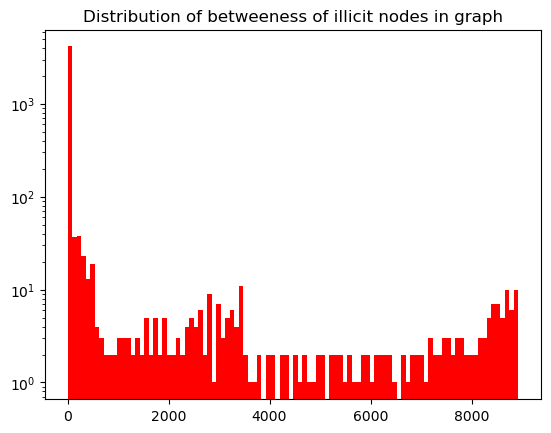

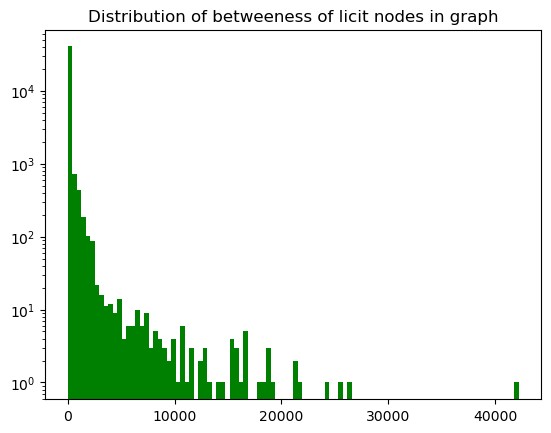

In [37]:
x = pd.Series(tx_graph.betweenness(illicit_vertices))

hist, bins, _ = plt.hist(x, bins=100, color = 'red')
plt.yscale('log')
plt.title("Distribution of betweeness of illicit nodes in graph")
plt.show()

x = pd.Series(tx_graph.betweenness(licit_vertices))

hist, bins, _ = plt.hist(x, bins=100, color = 'green')
plt.yscale('log')
plt.title("Distribution of betweeness of licit nodes in graph")
plt.show()

### Plotting two different timesteps to see different nodes configurations

In [ ]:
subv_list = list(edges_dict[i] for i in df.index[df['time_step']==35])
subgraph = tx_graph.induced_subgraph(subv_list)

layout = subgraph.layout('drl')

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(subgraph, 
        vertex_size=10, 
        edge_arrow_size=2, 
        edge_arrow_width=2, 
        edge_width=1, 
        target=ax, 
        vertex_frame_width=0.2,
        layout=layout
       )

In [ ]:
subv_list = list(edges_dict[i] for i in df.index[df['time_step']==32])
subgraph = tx_graph.induced_subgraph(subv_list)

layout = subgraph.layout('drl')

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(subgraph, 
        vertex_size=10, 
        edge_arrow_size=2, 
        edge_arrow_width=2, 
        edge_width=1, 
        target=ax, 
        vertex_frame_width=0.2,
        layout=layout
       )

## Generating samples from feature distributions, for developing new samples


This method was used for a previous approach that finally was not conceived for the final presentation.

In [11]:
# Merge df_features and df_classes on their indices if they have the same index
merged_df = pd.merge(df_features, df_classes, left_index=True, right_index=True)

# Filter the rows with class 'unknown'
unknown_df = merged_df[merged_df['class'] == 'unknown']
known_df = merged_df[merged_df['class'] != 'unknown']

In [ ]:
from scipy import stats

mean, std = stats.norm.fit(df['feature_name'])

new_samples = np.random.normal(loc=mean, scale=std, size=100)

plt.figure(figsize=(12, 6))
sns.histplot(df['feature_name'], kde=True, color='blue', label='Original Data')
sns.histplot(new_samples, kde=True, color='red', label='Sampled Data', alpha=0.5)
plt.legend()
plt.title('Comparison of Distributions')
plt.show()

In [14]:
unknown_df = unknown_df.drop(columns=['class'])
known_df = known_df.drop(columns=['class'])


In [5]:
# Create a new DataFrame to store the generated samples for each feature
generated_samples_df = pd.DataFrame()

# Iterate over each feature
for column in unknown_df.columns:
    # Fit a normal distribution to the feature
    mean, std = stats.norm.fit(unknown_df[column])
    
    # Generate new samples based on the fitted distribution
    new_samples = np.random.normal(loc=mean, scale=std, size=200000)
    
    # Store the generated samples in the new DataFrame
    generated_samples_df[column] = new_samples




In [6]:
generated_samples_df

0          1         2         3         4         5  \
0       2.095166e+08  21.319806  0.098368 -1.141105  0.784997  0.412005   
1       5.273241e+07  13.435611  2.523193 -0.912169 -0.822269  0.131225   
2       2.469610e+08  13.461719 -0.944553 -0.897397 -0.960114  0.785165   
3       2.091541e+08   9.493924  0.030648  1.110619  0.667115  0.525806   
4       1.746383e+08  21.001382  0.078330 -1.007225 -0.973947 -0.216082   
...              ...        ...       ...       ...       ...       ...   
199995  7.048773e+07  35.955494  0.486220 -0.786548 -1.104078  0.121515   
199996  2.401784e+08  40.040768 -1.922158  0.483242 -1.508054 -0.448302   
199997  2.512465e+08   7.955170  0.217049  1.445208  1.068984  0.819005   
199998  5.513256e+07  15.350277 -3.384141 -0.068675  1.136386 -0.073517   
199999  2.581152e+08  49.571637  0.167844  0.519617  0.707236  0.539738   

               6         7         8         9  ...       158       159  \
0      -0.473970  0.898033  0.192797 -0.764598  ... -0.399732  3.654261   
1       1.293170 -0.280649  0.781211 -0.471259  ... -0.990405  0.433692   
2      -0.001033 -0.275545  0.090804  1.797431  ...  0.634091 -0.862117   
3       0.658723 -0.332623 -1.059899  0.209956  ... -0.947459  0.067039   
4      -0.192862  0.041539 -0.650344  0.666951  ...  0.184029  2.021281   
...          ...       ...       ...       ...  ...       ...       ...   
199995 -1.767920  1.484277  1.982769 -1.591384  ... -0.172256 -1.487172   
199996 -0.184524  0.167543  0.469485 -0.130391  ...  0.691952  0.457246   
199997 -0.379182 -0.539615 -1.198225  2.152573  ... -1.209215  0.955053   
199998  0.175032  0.227778 -1.836151  1.455900  ...  0.081578  0.934696   
199999 -0.543941  0.037615 -1.261471 -0.813807  ...  0.424300  0.173585   

             160       161       162       163       164       165       166  \
0      -1.080526 -0.843370 -0.818326  0.467023 -0.701195  1.277556 -0.431282   
1       0.261041  0.280856  0.347106  0.992309 -0.374319  0.738452  1.838491   
2       0.122708 -0.492397  0.541418  0.589350 -2.153016  0.317344 -0.661764   
3       0.118592 -0.517267  1.071379 -0.207915 -0.781270  0.751871 -1.679944   
4      -0.976063  0.672646  0.695237  0.162887  0.878977 -0.428093  1.365525   
...          ...       ...       ...       ...       ...       ...       ...   
199995 -1.840130 -0.418459  0.940266 -0.994164  0.130941 -0.529736  0.386472   
199996  0.594257  0.548396  1.007970 -0.641616 -0.923213 -1.030502 -0.662352   
199997  0.462468 -0.312641 -0.987297 -0.665560  1.231099  0.541540  0.264655   
199998  0.033857 -1.056044  1.292561  1.266720 -0.652054  0.927233  1.065827   
199999  0.010318  0.185692 -0.563216  0.284024 -0.068782  0.426863 -1.899586   

                txId  
0      -1.390887e+07  
1      -1.884765e+07  
2       9.042256e+07  
3       2.325777e+08  
4       7.505525e+07  
...              ...  
199995  2.651664e+08  
199996  2.835053e+08  
199997  2.366681e+08  
199998  4.459925e+07  
199999 -3.704487e+07  

[200000 rows x 168 columns]

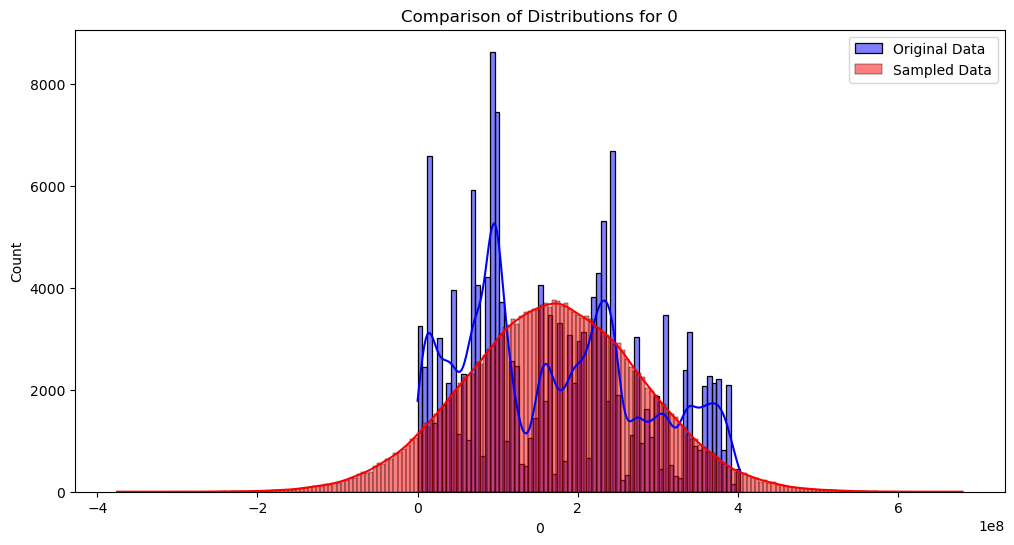

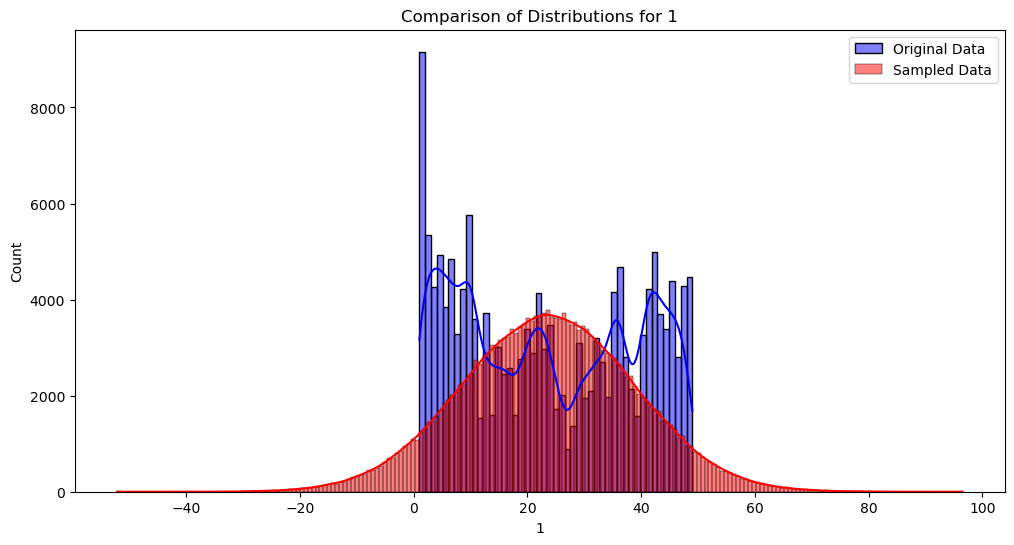

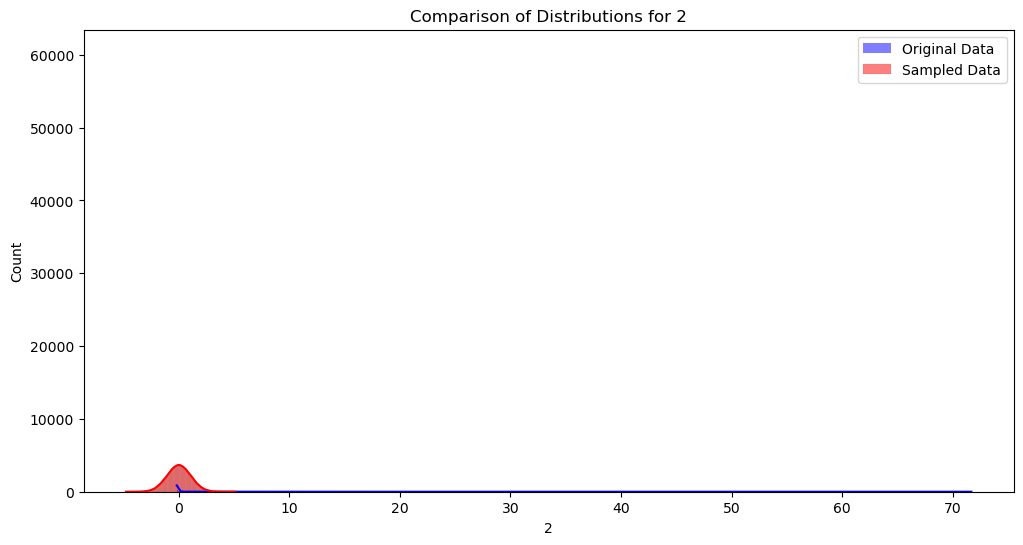

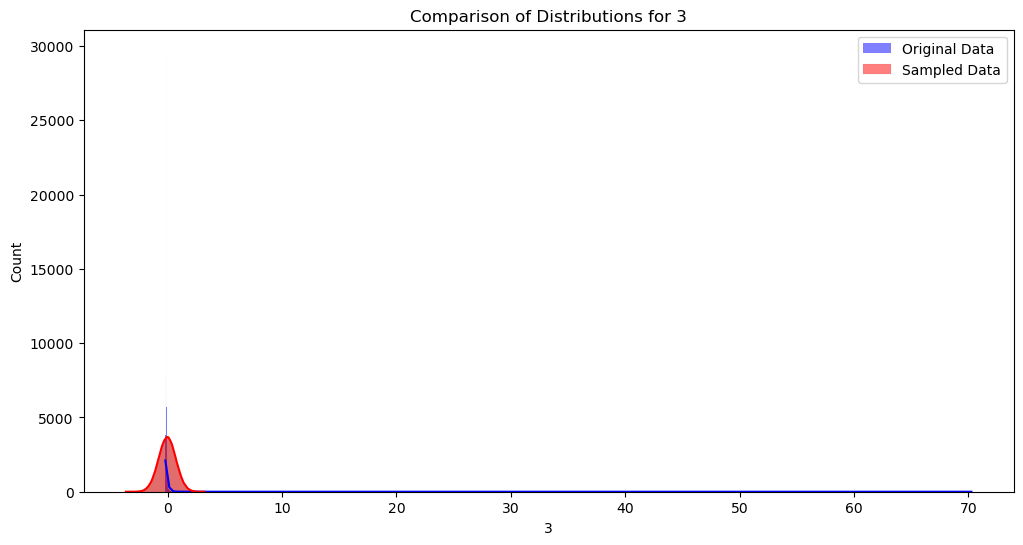

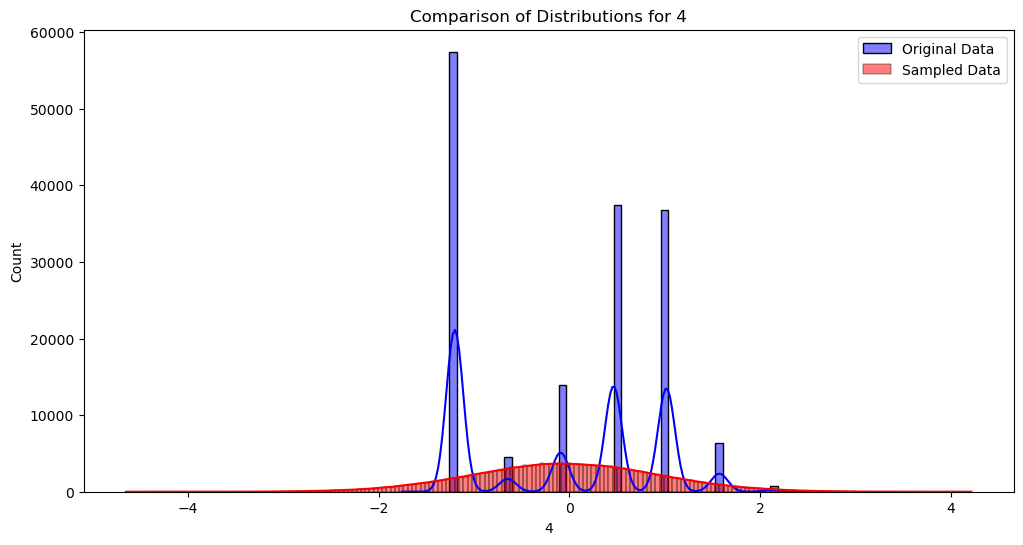

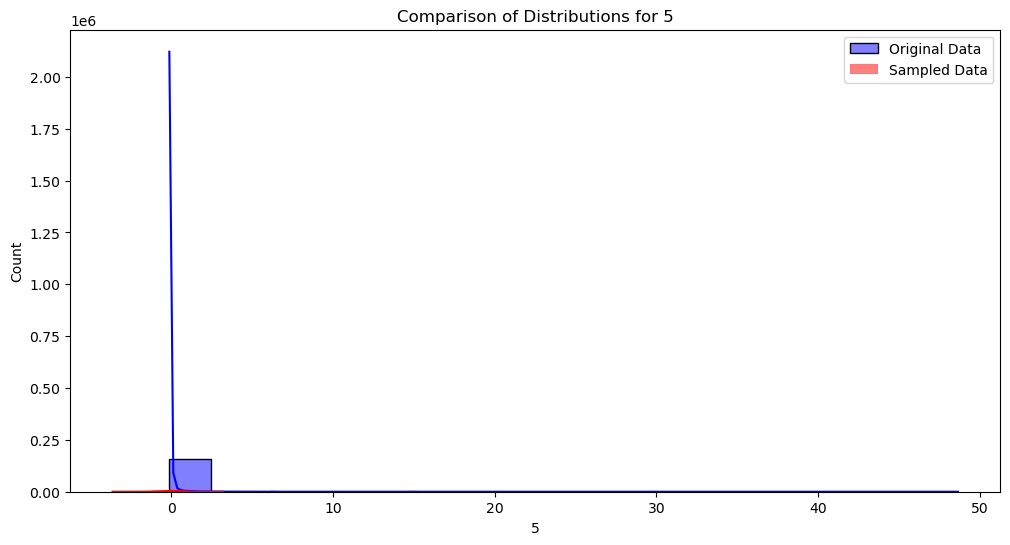

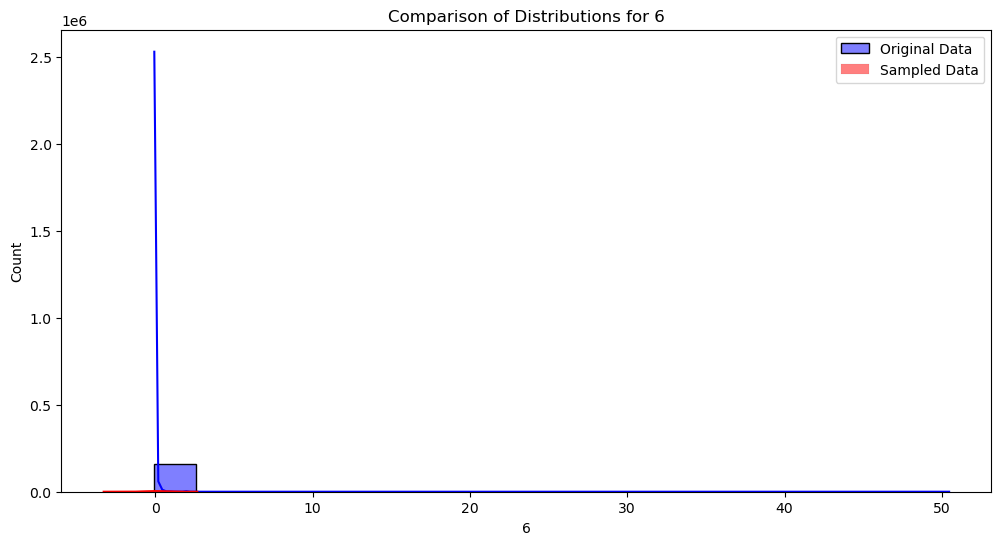

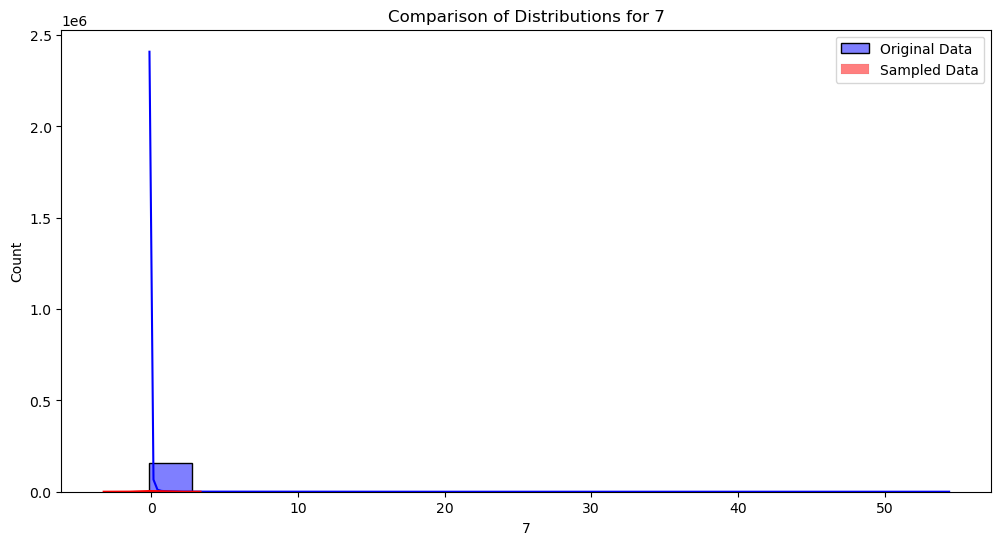

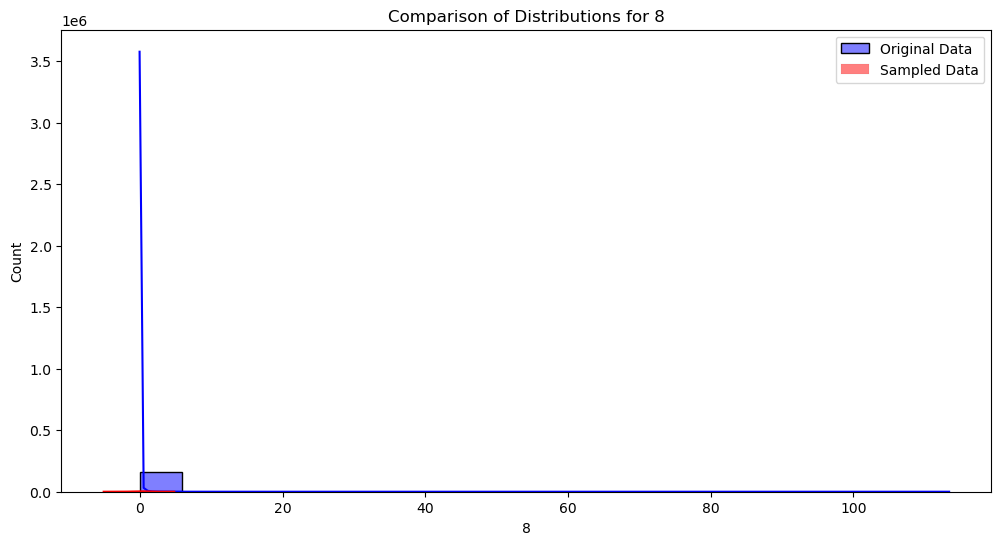

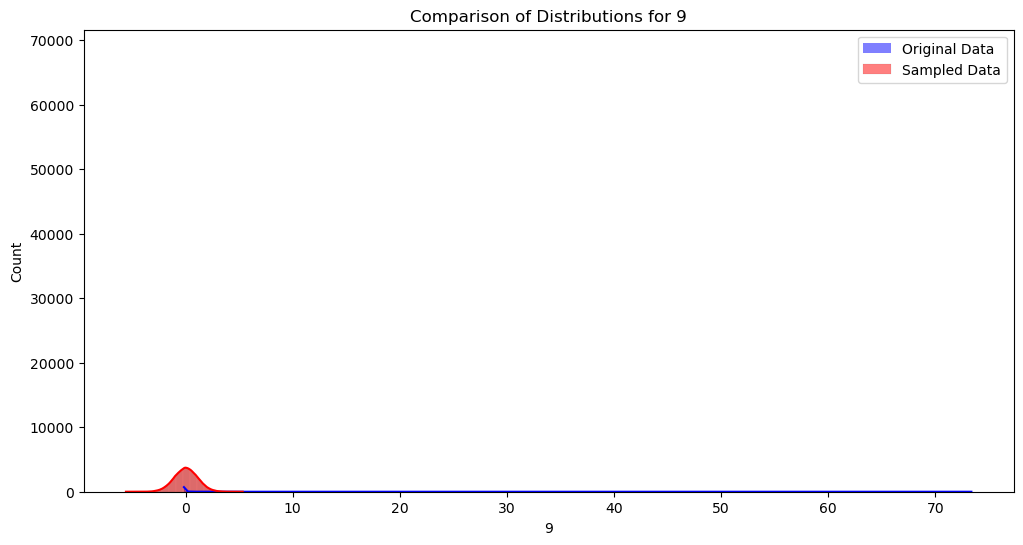

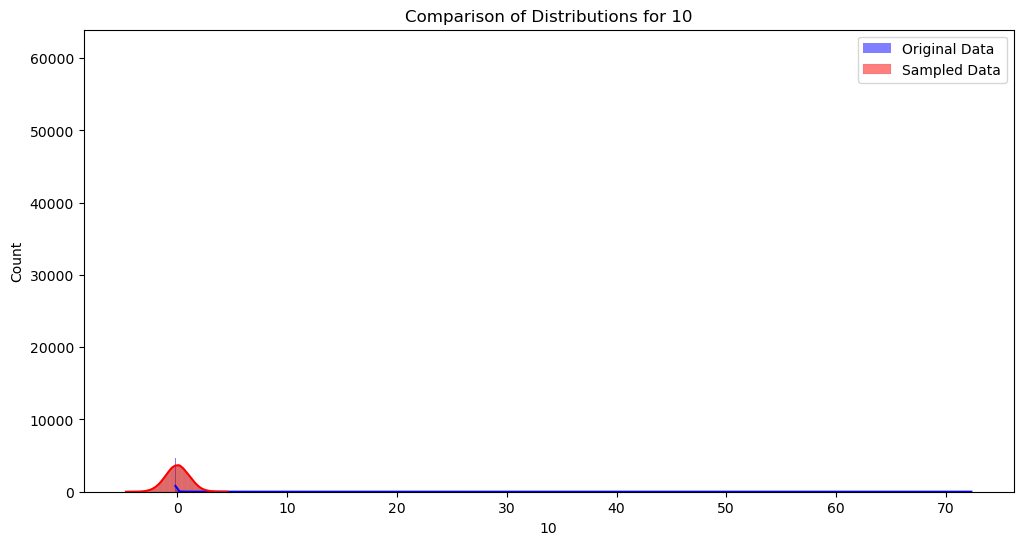

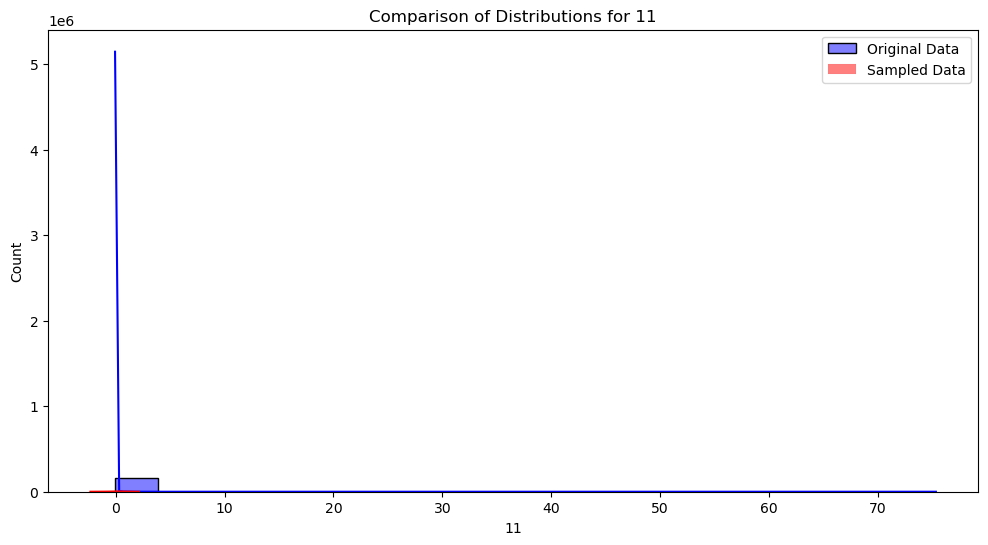

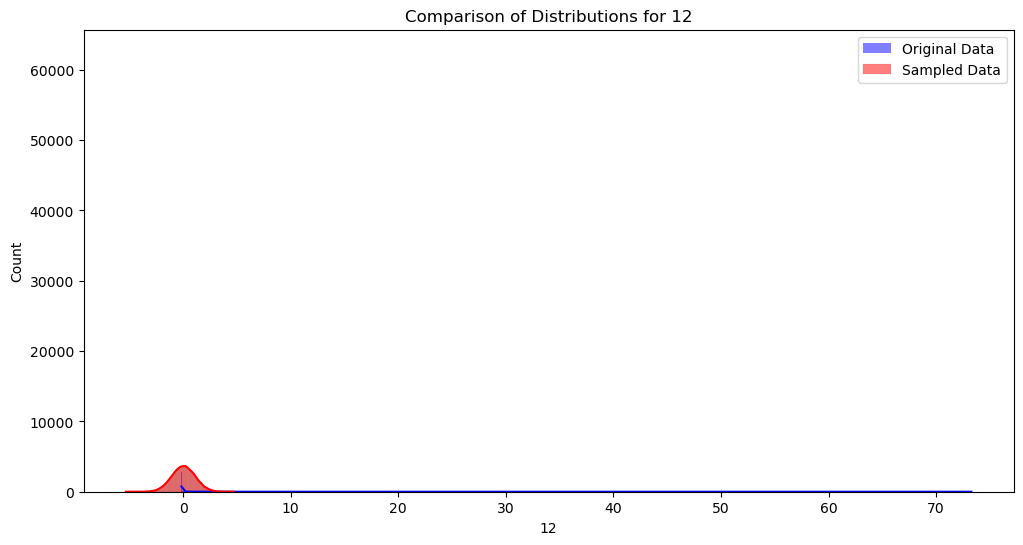

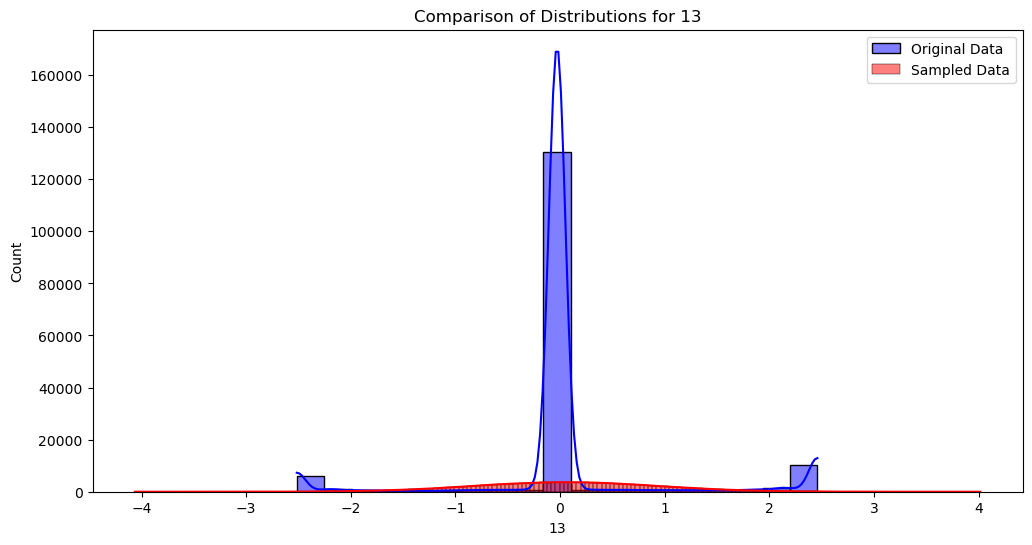

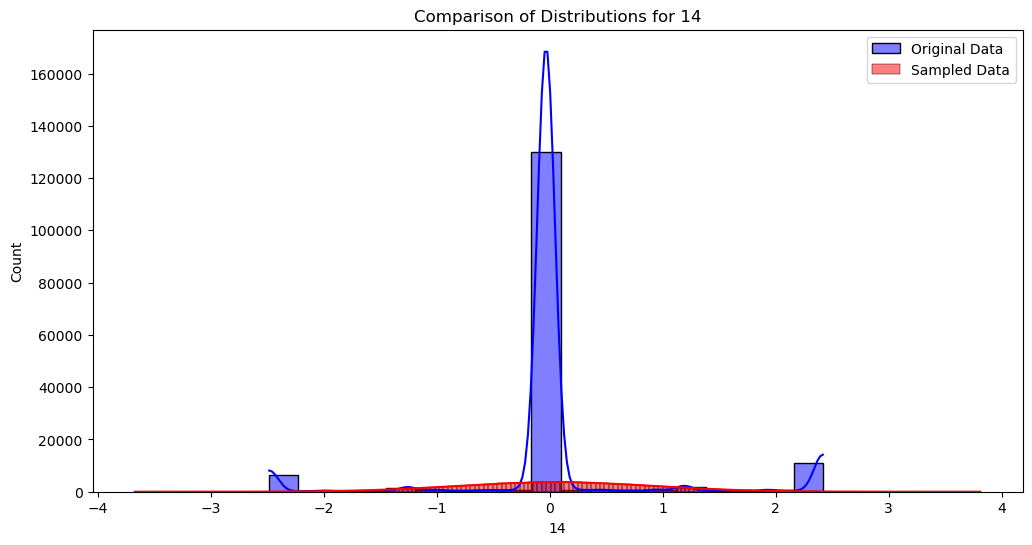

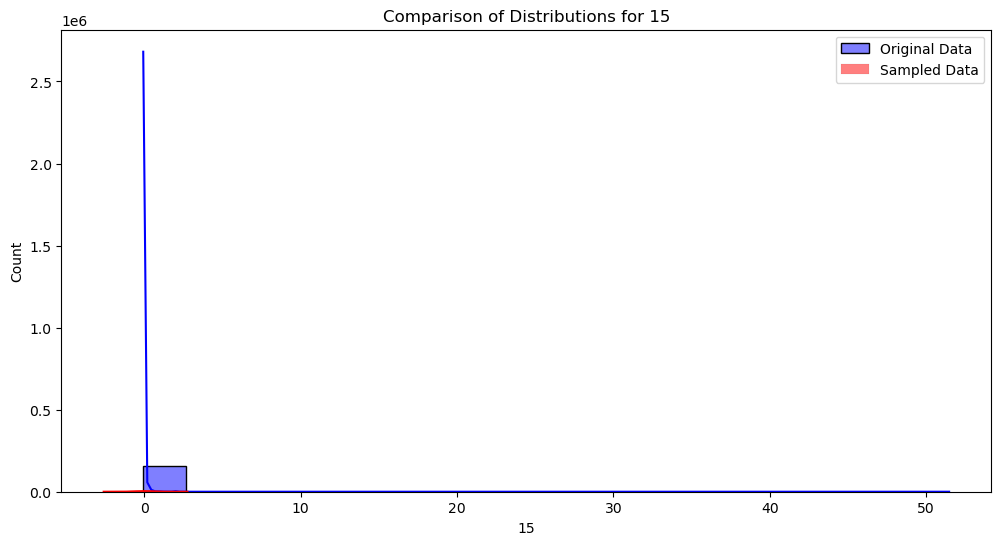

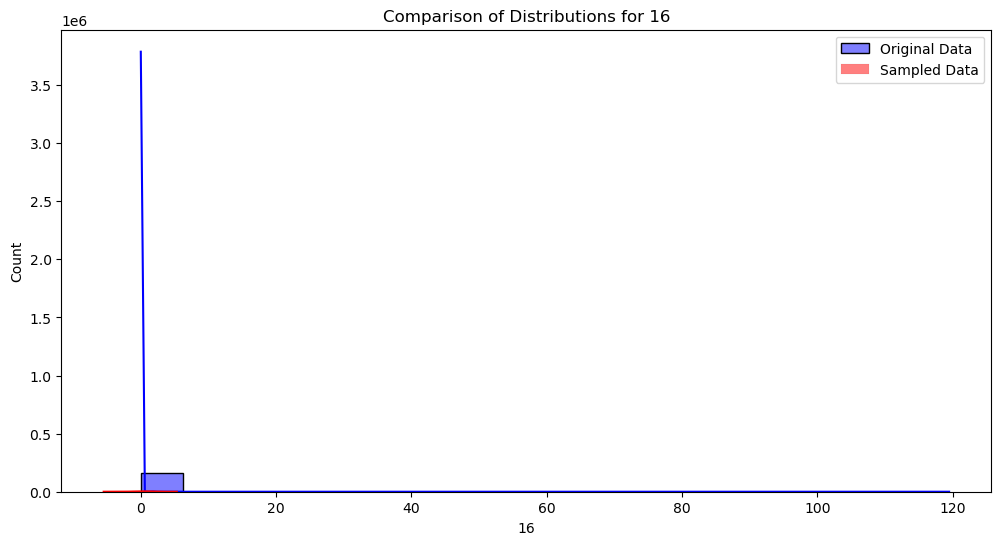

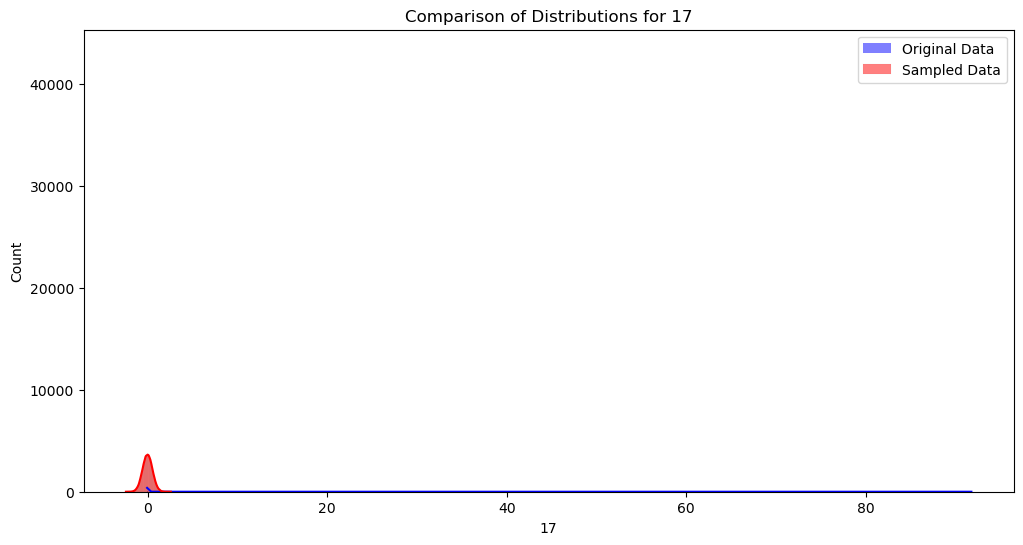

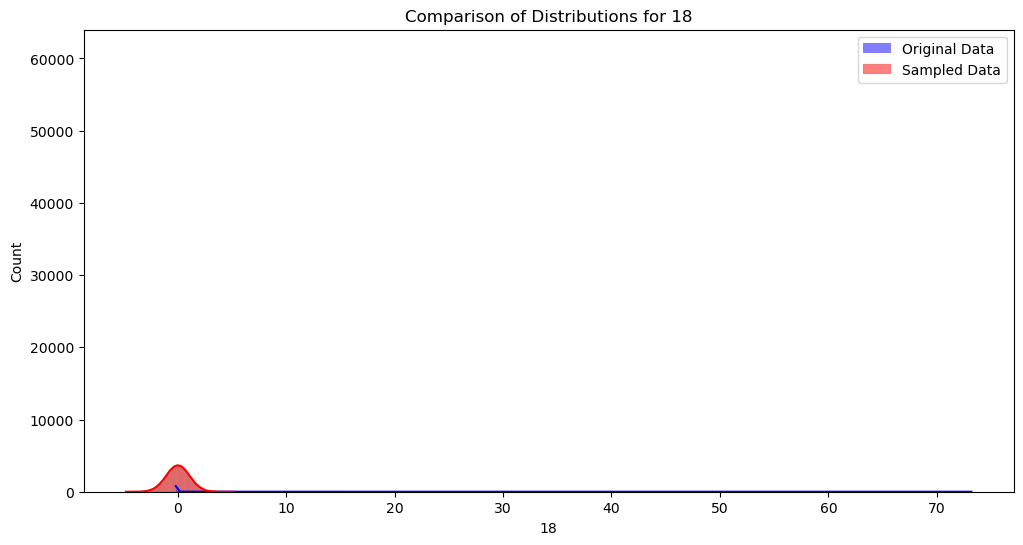

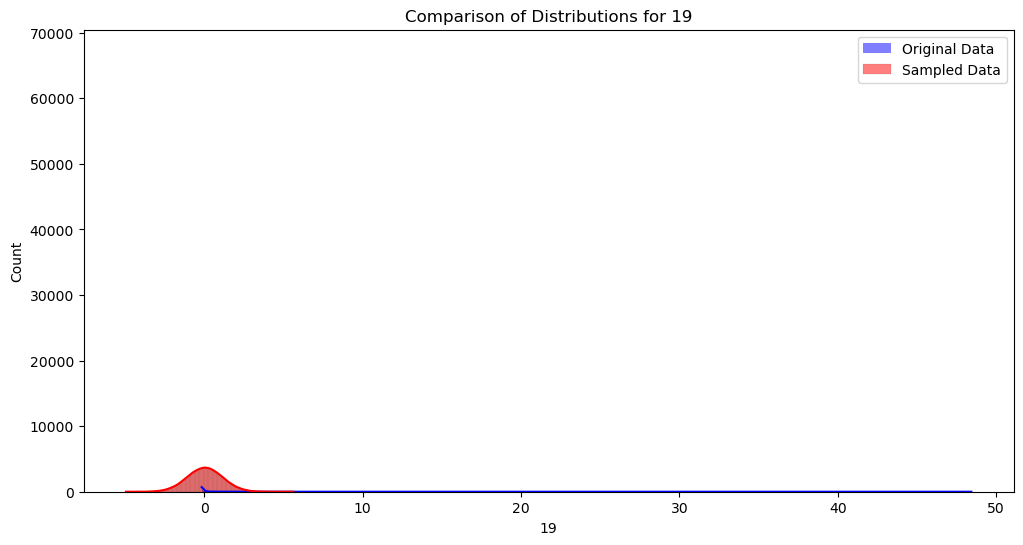

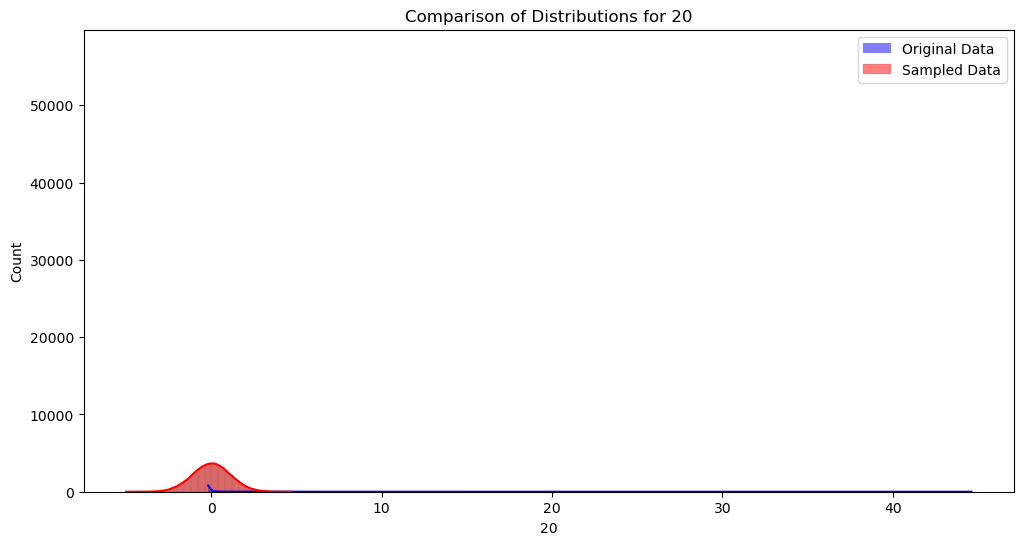

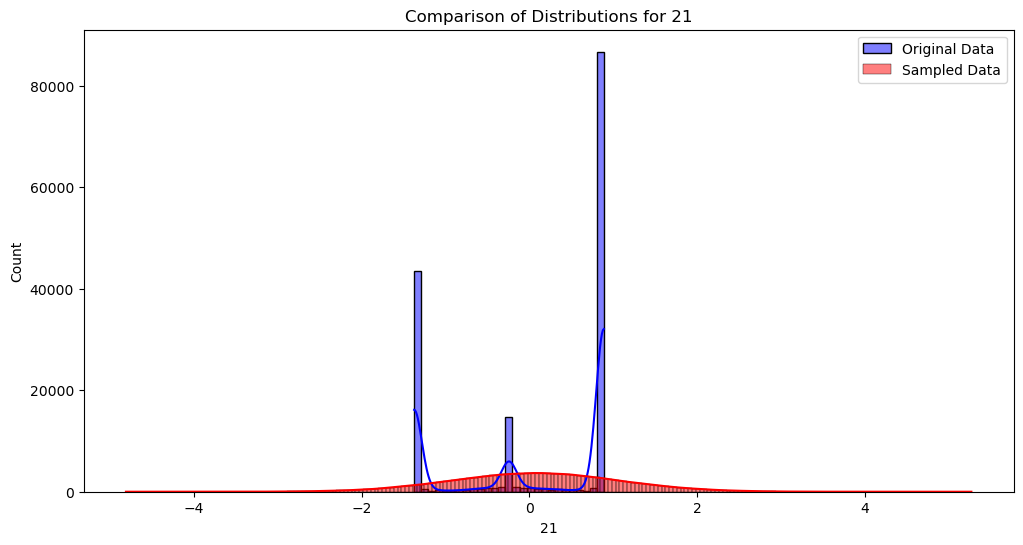

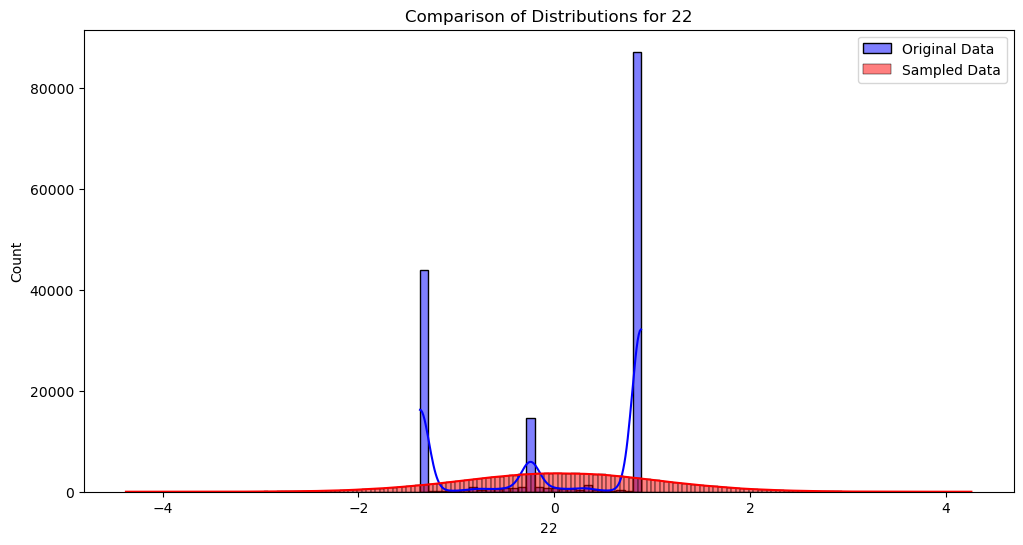

In [7]:
for column in unknown_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(unknown_df[column], kde=True, color='blue', label='Original Data')
    sns.histplot(generated_samples_df[column], kde=True, color='red', label='Sampled Data', alpha=0.5)
    plt.legend()
    plt.title(f'Comparison of Distributions for {column}')
    plt.show()

In [6]:
import numpy as np

In [7]:
new_data = pd.DataFrame()

for feature_name in unknown_df.columns:
    # Sample new data from the empirical distribution of the original data
    new_samples = np.random.choice(unknown_df[feature_name], size=200000, replace=True)
    
    # Store the new samples in the new dataframe
    new_data[feature_name] = new_samples

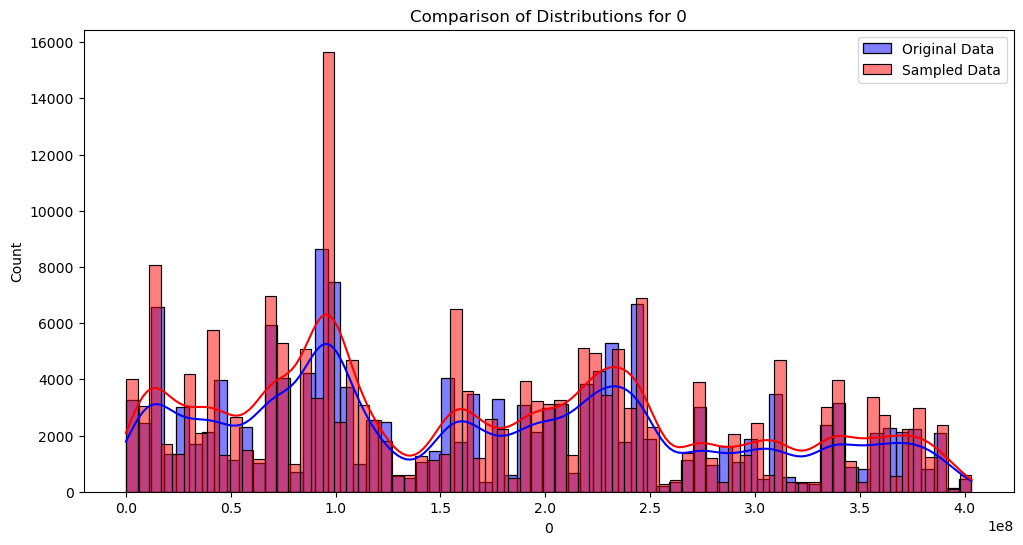

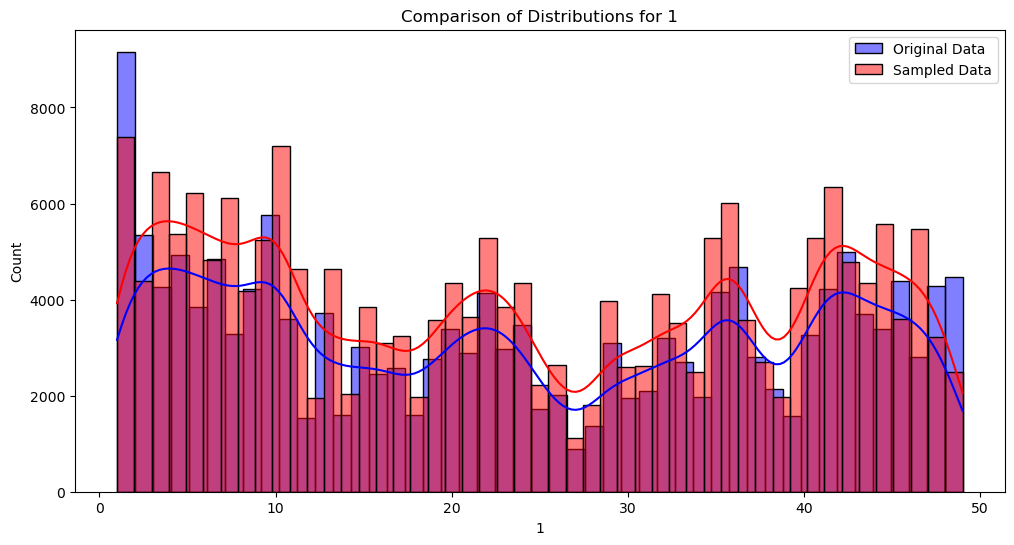

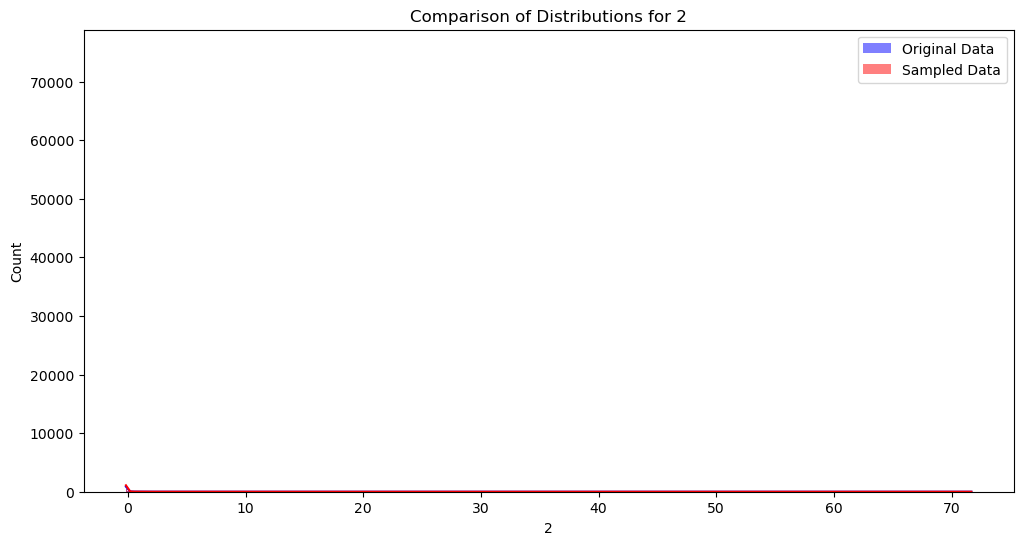

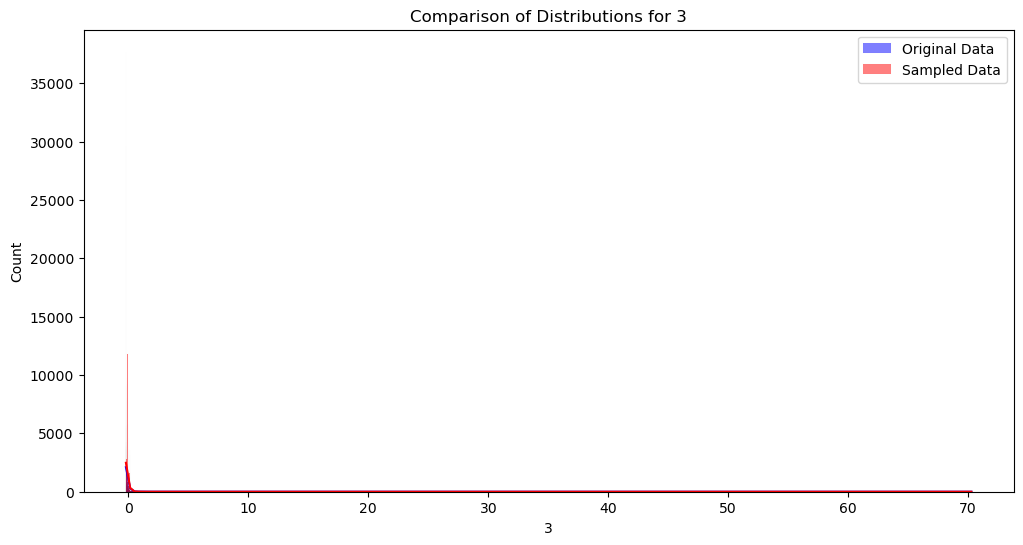

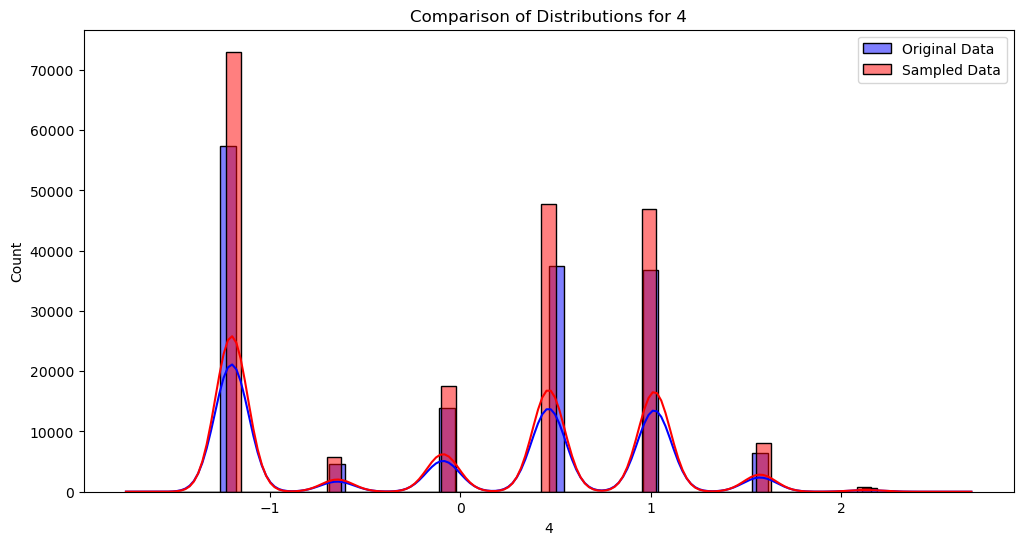

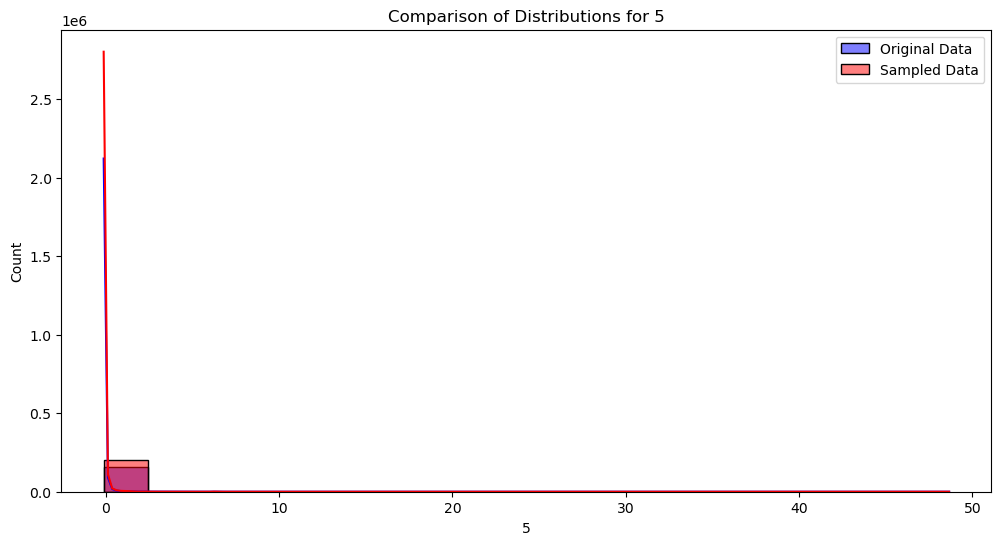

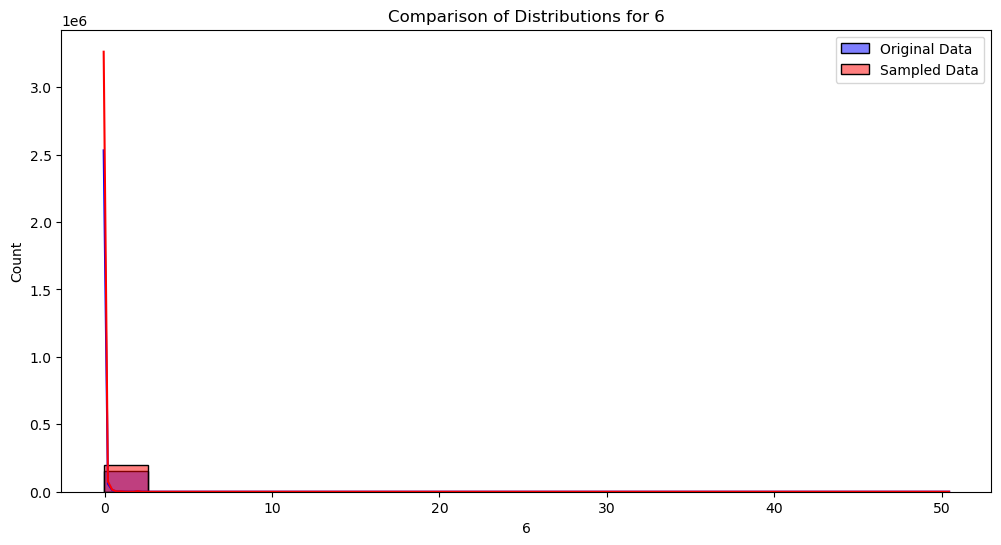

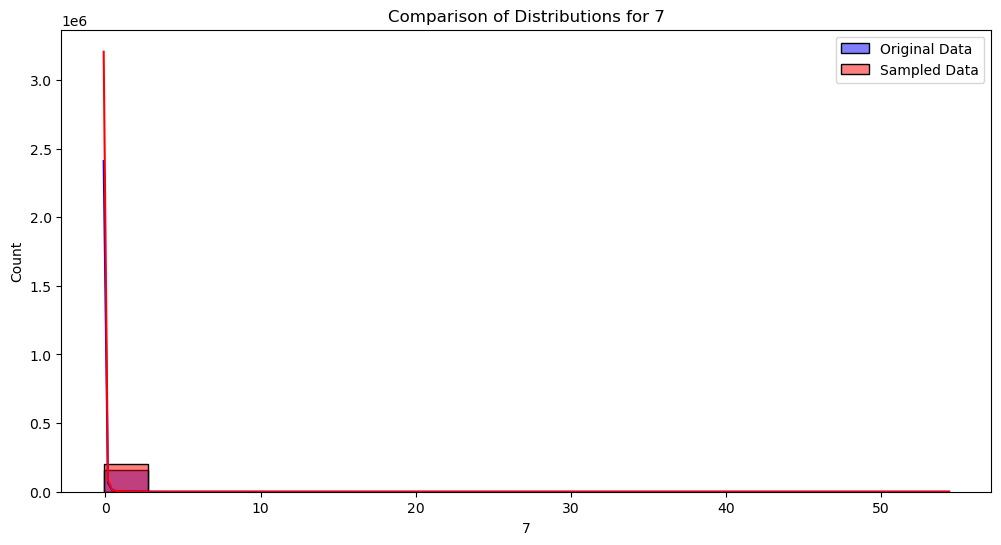

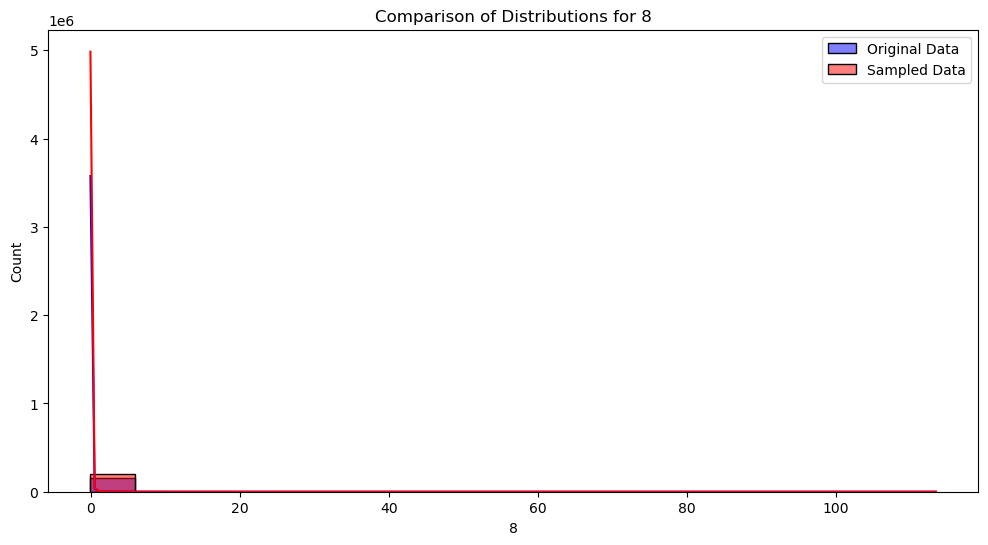

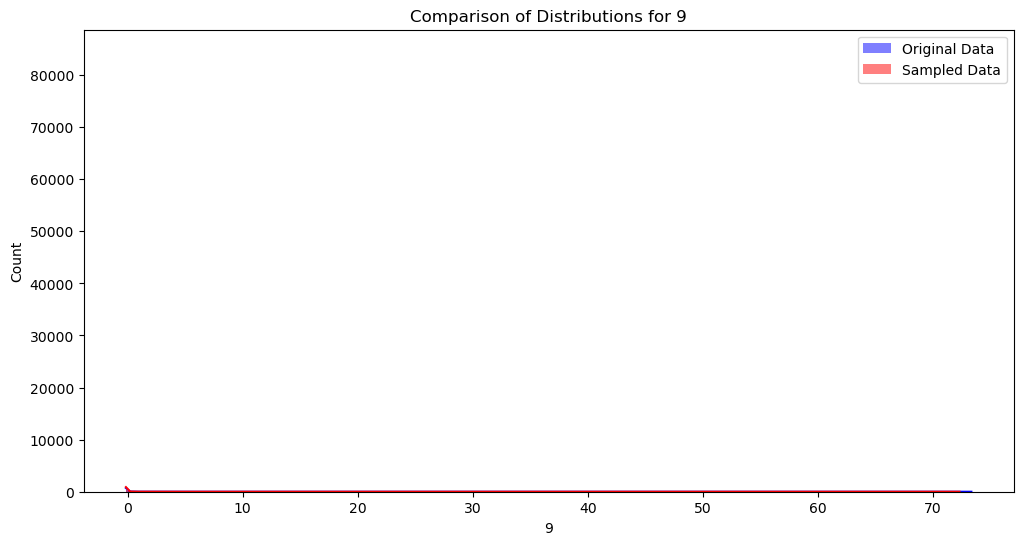

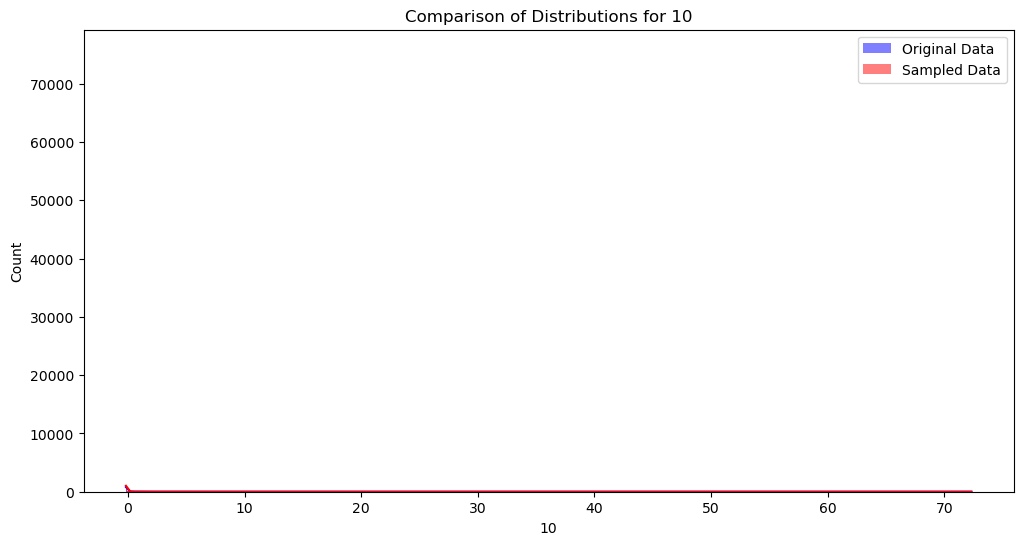

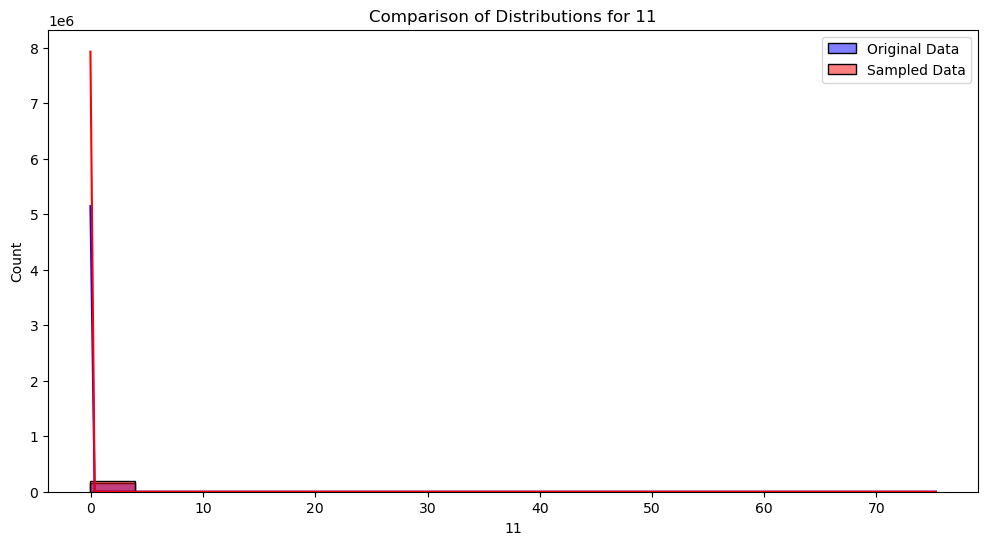

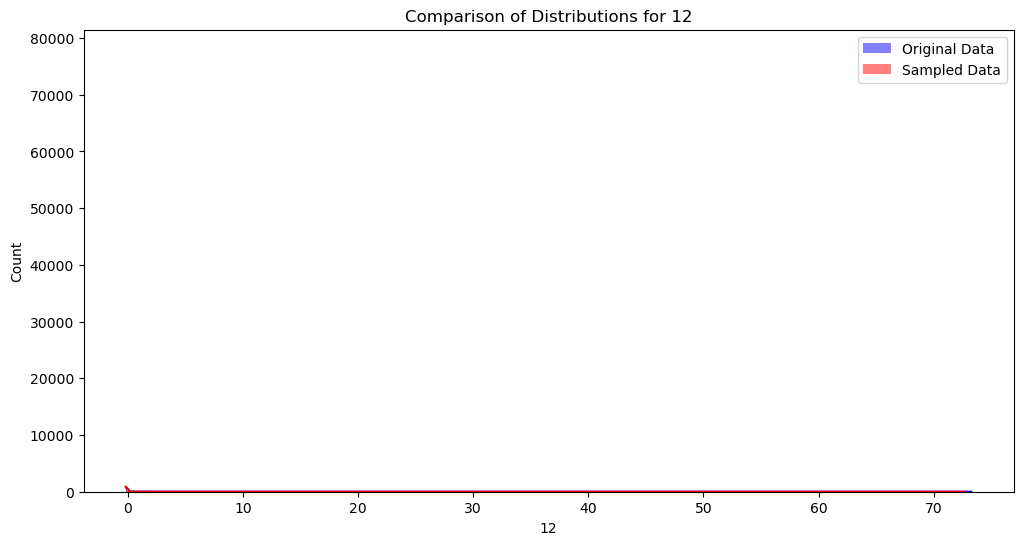

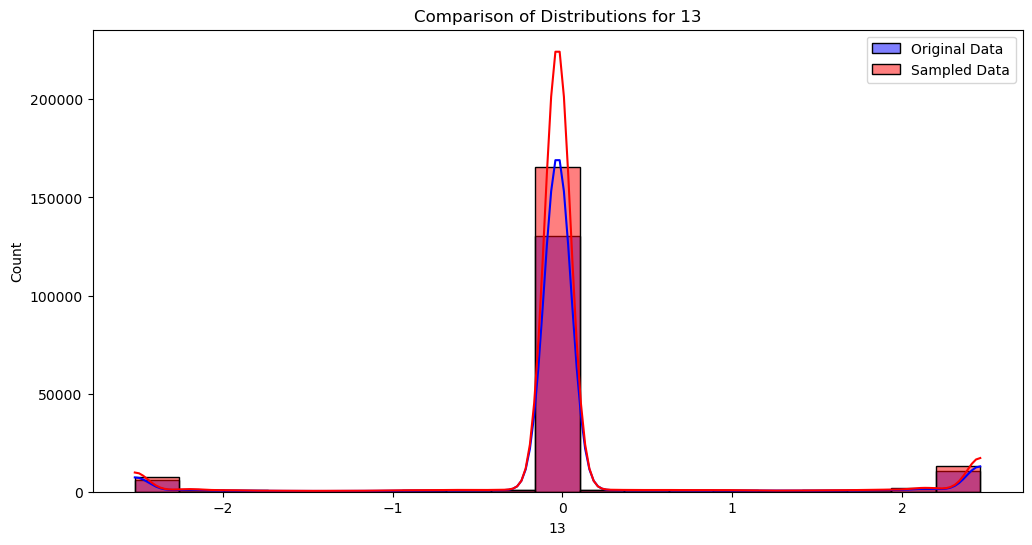

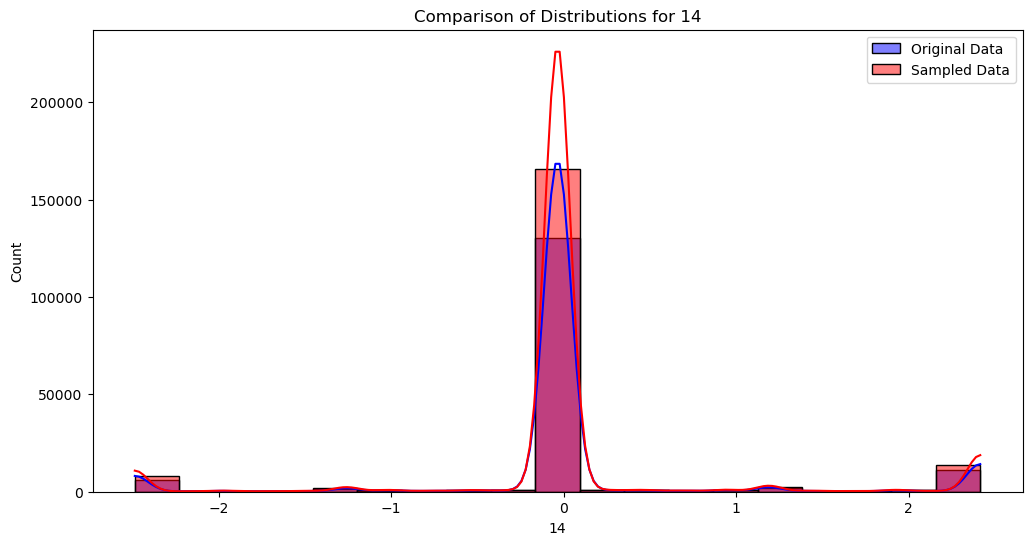

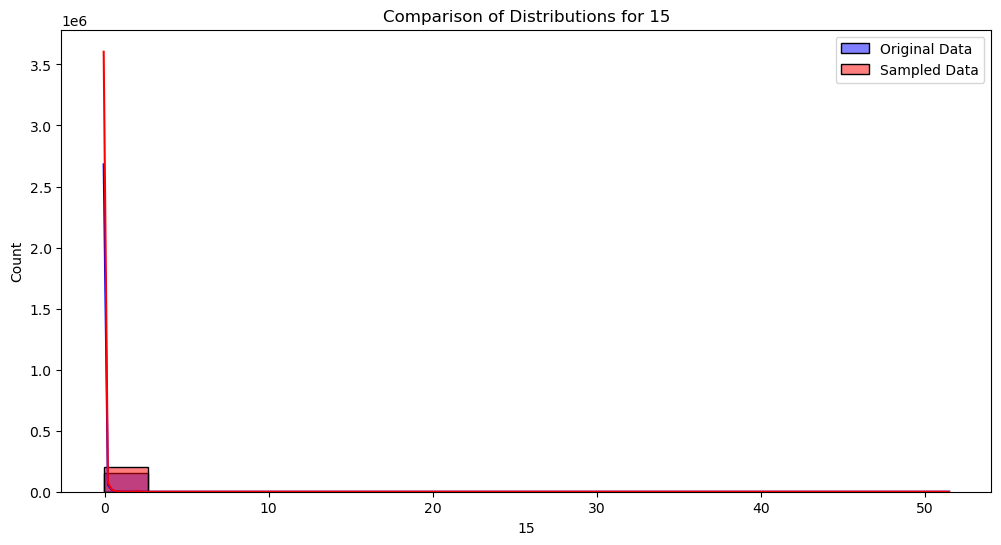

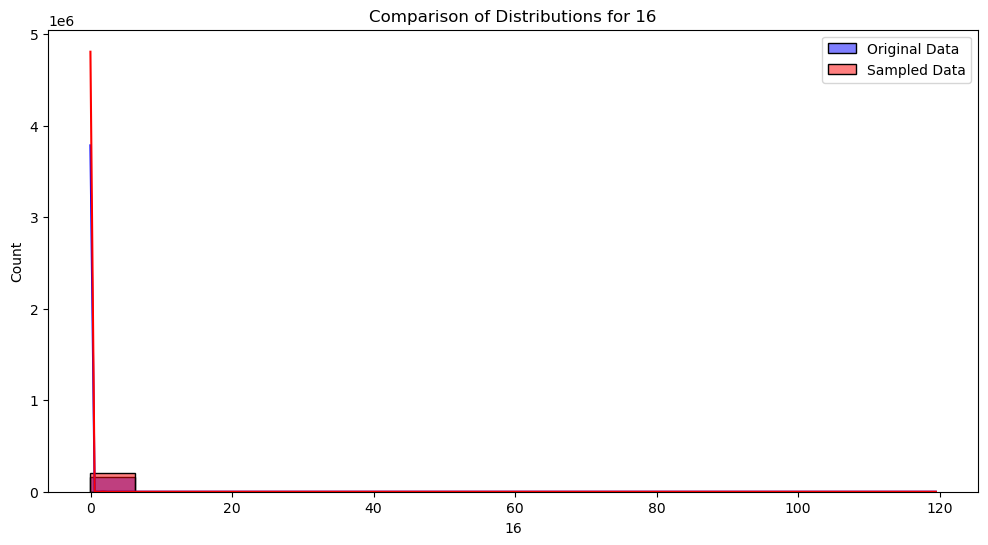

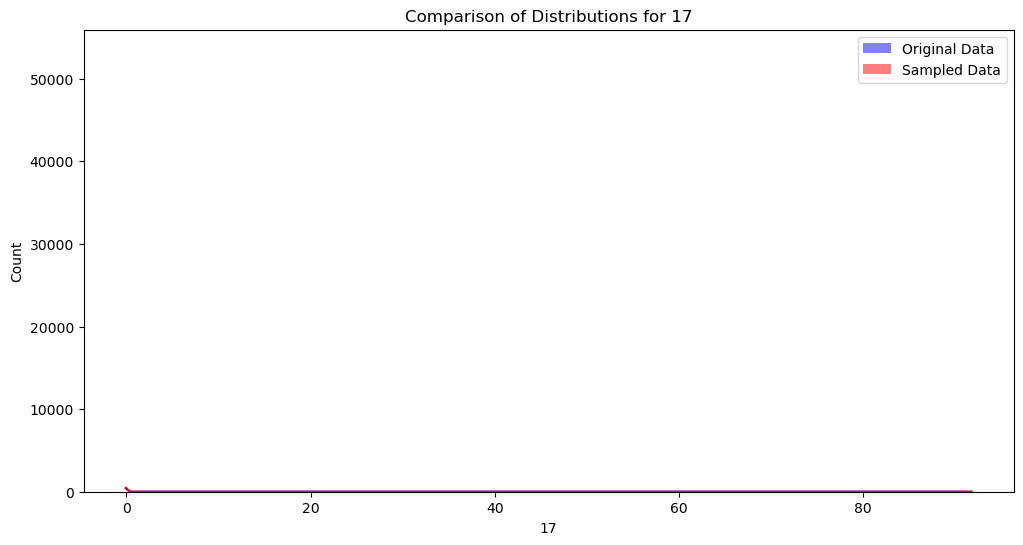

KeyboardInterrupt: 

In [10]:
for column in unknown_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(unknown_df[column], kde=True, color='blue', label='Original Data')
    sns.histplot(new_data[column], kde=True, color='red', label='Sampled Data', alpha=0.5)
    plt.legend()
    plt.title(f'Comparison of Distributions for {column}')
    plt.show()

In [15]:
new_data_2 = pd.DataFrame()

for feature_name in unknown_df.columns:
    # Sample new data from the empirical distribution of the original data
    new_samples = np.random.choice(known_df[feature_name], size=200000, replace=True)
    
    # Store the new samples in the new dataframe
    new_data_2[feature_name] = new_samples

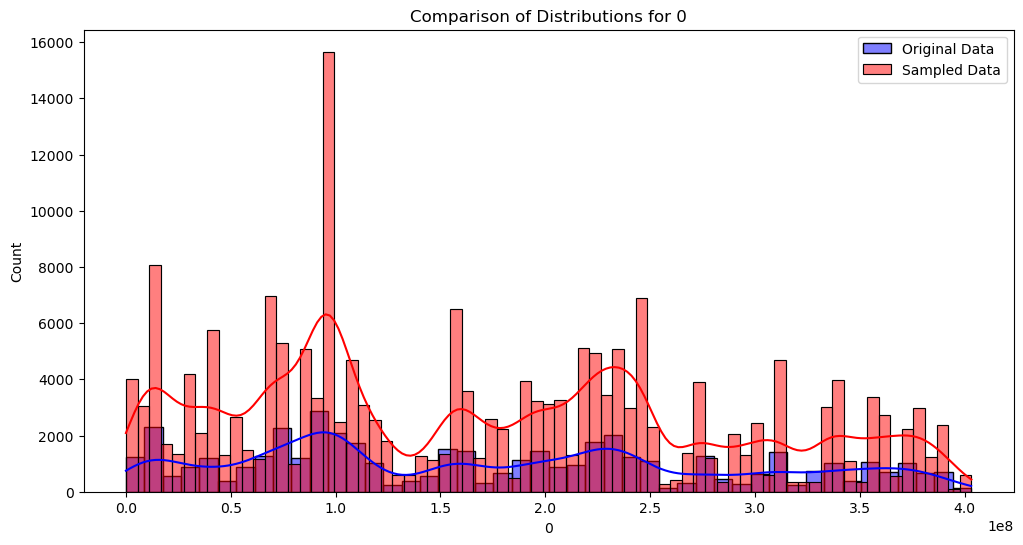

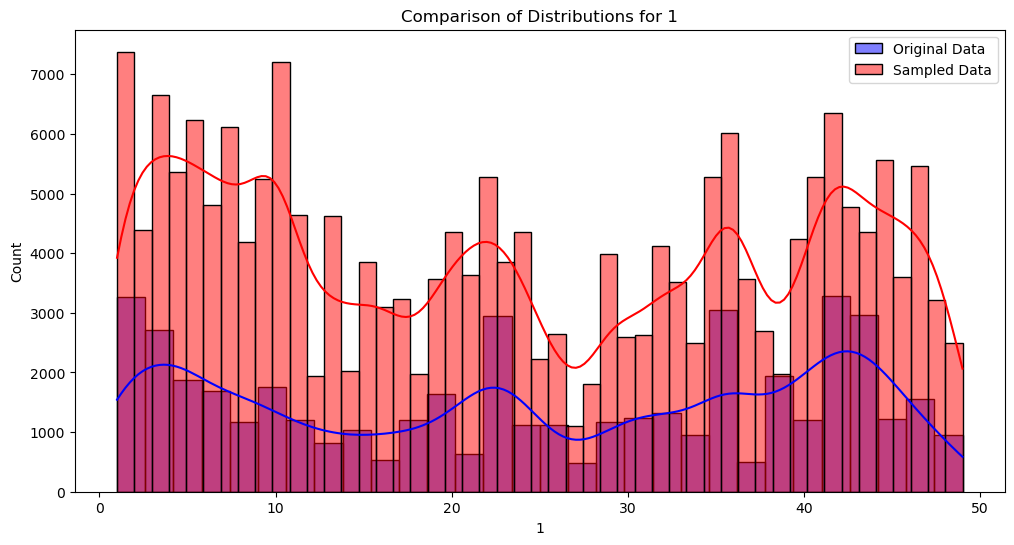

KeyboardInterrupt: 

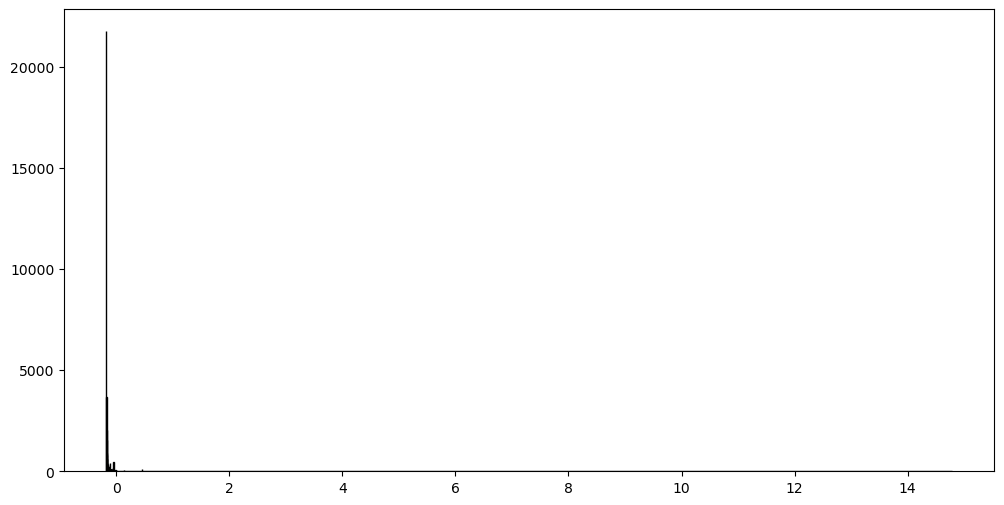

In [16]:
for column in unknown_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(known_df[column], kde=True, color='blue', label='Original Data')
    sns.histplot(new_data[column], kde=True, color='red', label='Sampled Data', alpha=0.5)
    plt.legend()
    plt.title(f'Comparison of Distributions for {column}')
    plt.show()